In [1]:
import os
import json
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorly as ts
from scipy import stats
from scipy.spatial import distance

In [2]:
# The manipulation and extraction procedures of the .json files obtained from Sonar output is copied from
# https://github.com/fga-eps-mds/Analytics, developed by Gabriel Filipe Manso in context of teacher assistant activities
# in EPS and MDS courses in 2020.2 academic period, under supervising by prof. Hilmer R. Neri in University of Brazilia,
# Faculty of Gama- Software Engineering graduate course.
# https://github.com/fga-eps-mds/A-Disciplina-MDS-EPS/blob/master/PlanosDeEnsino/EPS-cronograma-2020-2-hrn.md
# https://github.com/fga-eps-mds/A-Disciplina-MDS-EPS/blob/master/PlanosDeEnsino/MDS-cronograma-hrn.md
from scipy.stats import mannwhitneyu

%config InlineBackend.figure_format ='retina'

sns.set(font_scale=1.5)

sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
repos = ['frontend',
         'gateway',
         'etl_tse',
         'etl_twitter',
         'etl_camara',
         'etl_news']

language = [['frontend', 'js'],
            ['gateway', 'py'],
            ['etl_tse', 'py'],
            ['etl_twitter', 'py'],
            ['etl_camara', 'py'],
            ['etl_news', 'py']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]


In [5]:
jsons = glob('data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/*.json')

In [6]:
jsons

['data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-etl_camara-10-05-2021(1).json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-gateway-09-05-2021(2).json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-etl_camara-04-05-2021.json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-etl_camara-09-05-2021(1).json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-etl_twitter-10-05-2021(1).json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-etl_tse-19-05-2021.json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-etl_news-09-05-2021(2).json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-frontend-04-05-2021.json',
 'data/fga-eps-mds-2020-2-data/parlamentaqui/analytics-raw-data/fga-eps-mds-2020_2-gateway-19-05-2

In [7]:
def read_json(json_path):

    with open(json_path) as json_file:
        json_obj = json.load(json_file)

    return json_obj

In [8]:
def create_base_component_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [9]:
base_component_df = create_base_component_df(jsons)

In [10]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
508,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
509,functions,30,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
510,security_rating,3.0,False,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
511,files,5,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
512,complexity,88,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
513,ncloc,525,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
514,coverage,0.0,False,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
515,reliability_rating,1.0,True,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
516,comment_lines_density,9.2,False,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
106,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021


In [11]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [12]:
def metric_per_file(json):

    file_json = []

    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)

    return file_json

In [13]:
def generate_file_dataframe(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [14]:
def generate_file_dataframe_per_release(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [15]:
def create_file_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        file_component_data = metric_per_file(file_component)
        file_name = os.path.basename(i)

        file_repository = file_name.split("-", 5)[4]
        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list,
                                                                file_component_data,
                                                                language_extension = file_language)
        file_component_df['filename'] = file_name

        df = df.append(file_component_df, ignore_index=True)

    # replace TeamName by yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [16]:
file_component_df = create_file_df(jsons)

In [17]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
560,src/api/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
561,src/etl/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
562,src/api/api.py,25,82,13.1,0.0,0.0,345,3.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
563,src/app.py,1,2,0.0,0.0,0.0,20,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
564,src/models.py,4,4,0.6,0.0,0.0,160,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
95,src/api/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
96,src/etl/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
97,src/api/api.py,25,82,13.1,0.0,0.0,345,3.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
98,src/app.py,1,2,0.0,0.0,0.0,20,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
99,src/models.py,4,4,0.6,0.0,0.0,160,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021


In [18]:
# Create dataframe per repository

repository_dataframes = {}

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df

repository_dataframes.keys()

dict_keys(['frontend', 'gateway', 'etl_tse', 'etl_twitter', 'etl_camara', 'etl_news'])

In [19]:
# Defining measure em1 calculation, where em1 = density of non-complex file
def em1(df):
    m0 = np.median(df['complexity'].astype(float)/df['functions'].astype(float))
    m1 = df['complexity'].astype(float)
    m2 = df['functions'].astype(float)
    m3 = len(df) # total files

    #  intervals for em1 thresholds
    x = np.array([0, m0])
    y = np.array([1, 0])

    # Defining intervals for em1 interpretation(numeric interpolation). It indicates quality score
    IF1 = np.interp(list(((m1/m2) <= m0)[(m2 > 0)]),x, y)

    em1 = sum(IF1)/m3

    return em1

In [20]:
def em2(df):

    # Defining metrics for measure em2, where em2 = density of commented files
    m3 = len(df) # total files
    m4 = df['comment_lines_density'].astype(float)

    #  intervals for em1 thresholds
    x = np.array([0.1, 0.3])
    y = np.array([1, 0])

    # Defining intervals for em2 interpretation(numeric interpolation). It indicates quality score
    em2i = []
    for if2i in m4:
        if 10 <= if2i <= 30:
            em2i.append(np.interp(if2i/100,x, y))
        else:
            em2i.append(0)

    em2 = np.sum(em2i)/m3

    return em2

In [21]:
def em3(df):

    # Defining metrics for measure em3,where ma3 = absence of duplication on file (density)
    m3 = len(df) # total files
    m5 = df['duplicated_lines_density'].astype(float)

    #  intervals for em1 thresholds
    x = np.array([0, 0.05])
    y = np.array([1, 0])

    # Intervals for ma3 interpretation
    em3i = []
    for if3i in m5:
        if  if3i < 5:
            em3i.append(np.interp(if3i/100,x, y))
        else:
            em3i.append(0)

    em3 = np.sum(em3i)/m3

    return em3

In [22]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    em1_list = []
    em2_list = []
    em3_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        em1_list.append(em1(version_df))
        em2_list.append(em2(version_df))
        em3_list.append(em3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'em1': em1_list,
                               'em2': em2_list,
                               'em3': em3_list,
                               'repository': repository_list,
                               'version': version_list})

    return metrics_df

In [23]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df

In [60]:
repository_dataframes["frontend"].head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
593,src/Api.js,3,4,0.0,0.0,0.0,15,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
594,src/App.js,1,1,0.0,0.0,0.0,32,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
595,src/components/Breadcrumbs/tests/breadcrumbs.t...,1,1,0.0,0.0,0.0,15,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
596,src/components/DataVoting/DataVoting.js,5,8,4.5,0.0,0.0,107,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
597,src/components/DataVoting/DataVotingMobile.js,4,4,0.0,0.0,0.0,74,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
598,src/components/DeputiesList/DeputiesList.js,2,2,0.0,0.0,0.0,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
599,src/screens/DeputiesScreen.js,1,1,0.0,0.0,0.0,10,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
600,src/screens/DeputyProfileScreen.js,4,4,5.2,0.0,0.0,55,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
601,src/screens/ErrorScreen.js,1,1,0.0,0.0,0.0,9,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021
602,src/index.js,0,0,0.0,0.0,0.0,13,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-01-05-2021.json,frontend,01-05-2021


In [61]:
repository_metrics["frontend"]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.966667,0.049167,1.000000,frontend,01-05-2021,0.469564,0.469564,0.469564
1,0.966667,0.049167,1.000000,frontend,02-05-2021,0.469564,0.469564,0.469564
2,0.966667,0.082000,1.000000,frontend,04-05-2021,0.470085,0.470085,0.470085
3,0.968750,0.087344,0.937500,frontend,09-05-2021,0.455804,0.455804,0.455804
4,0.968750,0.087344,0.937500,frontend,09-05-2021(1),0.455804,0.455804,0.455804
5,0.968750,0.087344,0.937500,frontend,09-05-2021(2),0.455804,0.455804,0.455804
6,0.968750,0.057813,0.937500,frontend,10-05-2021,0.455268,0.455268,0.455268
7,0.971429,0.052857,0.944571,frontend,10-05-2021(1),0.457508,0.457508,0.457508
8,0.964286,0.071071,1.000000,frontend,18-04-2021,0.469325,0.469325,0.469325
9,0.972973,0.050000,0.947568,frontend,19-05-2021,0.458549,0.458549,0.458549


In [62]:
repository_metrics["gateway"]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.555556,0.0,1.0,gateway,01-05-2021,0.385972,0.385972,0.385972
1,0.555556,0.0,1.0,gateway,02-05-2021,0.385972,0.385972,0.385972
2,0.555556,0.0,1.0,gateway,04-05-2021,0.385972,0.385972,0.385972
3,0.555556,0.0,1.0,gateway,09-05-2021,0.385972,0.385972,0.385972
4,0.555556,0.0,1.0,gateway,09-05-2021(1),0.385972,0.385972,0.385972
5,0.555556,0.0,1.0,gateway,09-05-2021(2),0.385972,0.385972,0.385972
6,0.555556,0.0,1.0,gateway,10-05-2021,0.385972,0.385972,0.385972
7,0.555556,0.0,1.0,gateway,10-05-2021(1),0.385972,0.385972,0.385972
8,0.555556,0.0,1.0,gateway,18-04-2021,0.385972,0.385972,0.385972
9,0.600000,0.0,1.0,gateway,19-05-2021,0.393473,0.393473,0.393473


In [63]:
repository_metrics["etl_tse"]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.600000,0.0,1.0,etl_tse,01-05-2021,0.393473,0.393473,0.393473
1,0.600000,0.0,1.0,etl_tse,02-05-2021,0.393473,0.393473,0.393473
2,0.600000,0.0,1.0,etl_tse,04-05-2021,0.393473,0.393473,0.393473
3,0.600000,0.0,1.0,etl_tse,09-05-2021,0.393473,0.393473,0.393473
4,0.600000,0.0,1.0,etl_tse,09-05-2021(1),0.393473,0.393473,0.393473
5,0.600000,0.0,1.0,etl_tse,09-05-2021(2),0.393473,0.393473,0.393473
6,0.600000,0.0,1.0,etl_tse,10-05-2021,0.393473,0.393473,0.393473
7,0.600000,0.0,1.0,etl_tse,10-05-2021(1),0.393473,0.393473,0.393473
8,0.600000,0.0,1.0,etl_tse,18-04-2021,0.393473,0.393473,0.393473
9,0.666667,0.0,1.0,etl_tse,19-05-2021,0.405504,0.405504,0.405504


In [64]:
repository_metrics["etl_twitter"]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.600000,0.274,1.0,etl_twitter,01-05-2021,0.404187,0.404187,0.404187
1,0.600000,0.274,1.0,etl_twitter,02-05-2021,0.404187,0.404187,0.404187
2,0.600000,0.274,1.0,etl_twitter,04-05-2021,0.404187,0.404187,0.404187
3,0.600000,0.274,1.0,etl_twitter,09-05-2021,0.404187,0.404187,0.404187
4,0.600000,0.132,1.0,etl_twitter,09-05-2021(1),0.395985,0.395985,0.395985
5,0.600000,0.132,1.0,etl_twitter,09-05-2021(2),0.395985,0.395985,0.395985
6,0.600000,0.133,1.0,etl_twitter,10-05-2021,0.396023,0.396023,0.396023
7,0.600000,0.133,1.0,etl_twitter,10-05-2021(1),0.396023,0.396023,0.396023
8,0.600000,0.274,1.0,etl_twitter,18-04-2021,0.404187,0.404187,0.404187
9,0.666667,0.000,1.0,etl_twitter,19-05-2021,0.405504,0.405504,0.405504


In [65]:
repository_metrics["etl_camara"]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.600000,0.169000,1.0,etl_camara,01-05-2021,0.397583,0.397583,0.397583
1,0.600000,0.169000,1.0,etl_camara,02-05-2021,0.397583,0.397583,0.397583
2,0.600000,0.169000,1.0,etl_camara,04-05-2021,0.397583,0.397583,0.397583
3,0.600000,0.169000,1.0,etl_camara,09-05-2021,0.397583,0.397583,0.397583
4,0.600000,0.169000,1.0,etl_camara,09-05-2021(1),0.397583,0.397583,0.397583
5,0.600000,0.169000,1.0,etl_camara,09-05-2021(2),0.397583,0.397583,0.397583
6,0.600000,0.169000,1.0,etl_camara,10-05-2021,0.397583,0.397583,0.397583
7,0.600000,0.169000,1.0,etl_camara,10-05-2021(1),0.397583,0.397583,0.397583
8,0.600000,0.165000,1.0,etl_camara,18-04-2021,0.397391,0.397391,0.397391
9,0.666667,0.144167,1.0,etl_camara,19-05-2021,0.408411,0.408411,0.408411


In [66]:
repository_metrics["etl_news"]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.600000,0.1530,1.0,etl_news,01-05-2021,0.396845,0.396845,0.396845
1,0.600000,0.1530,1.0,etl_news,02-05-2021,0.396845,0.396845,0.396845
2,0.600000,0.1530,1.0,etl_news,04-05-2021,0.396845,0.396845,0.396845
3,0.600000,0.1530,1.0,etl_news,09-05-2021,0.396845,0.396845,0.396845
4,0.600000,0.1530,1.0,etl_news,09-05-2021(1),0.396845,0.396845,0.396845
5,0.600000,0.1530,1.0,etl_news,09-05-2021(2),0.396845,0.396845,0.396845
6,0.600000,0.1530,1.0,etl_news,10-05-2021,0.396845,0.396845,0.396845
7,0.600000,0.1530,1.0,etl_news,10-05-2021(1),0.396845,0.396845,0.396845
8,0.600000,0.1530,1.0,etl_news,18-04-2021,0.396845,0.396845,0.396845
9,0.666667,0.1425,1.0,etl_news,19-05-2021,0.408345,0.408345,0.408345


In [67]:
repos_metrics_list = []

repos_metrics_list.append(repository_metrics["frontend"])
repos_metrics_list.append(repository_metrics["gateway"])
repos_metrics_list.append(repository_metrics["etl_tse"])
repos_metrics_list.append(repository_metrics["etl_twitter"])
repos_metrics_list.append(repository_metrics["etl_camara"])
repos_metrics_list.append(repository_metrics["etl_news"])

#Printing frontend_metrics
#frontend_metrics


repos_metrics_list[0]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.966667,0.049167,1.000000,frontend,01-05-2021,0.469564,0.469564,0.469564
1,0.966667,0.049167,1.000000,frontend,02-05-2021,0.469564,0.469564,0.469564
2,0.966667,0.082000,1.000000,frontend,04-05-2021,0.470085,0.470085,0.470085
3,0.968750,0.087344,0.937500,frontend,09-05-2021,0.455804,0.455804,0.455804
4,0.968750,0.087344,0.937500,frontend,09-05-2021(1),0.455804,0.455804,0.455804
5,0.968750,0.087344,0.937500,frontend,09-05-2021(2),0.455804,0.455804,0.455804
6,0.968750,0.057813,0.937500,frontend,10-05-2021,0.455268,0.455268,0.455268
7,0.971429,0.052857,0.944571,frontend,10-05-2021(1),0.457508,0.457508,0.457508
8,0.964286,0.071071,1.000000,frontend,18-04-2021,0.469325,0.469325,0.469325
9,0.972973,0.050000,0.947568,frontend,19-05-2021,0.458549,0.458549,0.458549


## Plotting em1, em2 and em3 in frontend repository

### em1

(0.85, 1.0)

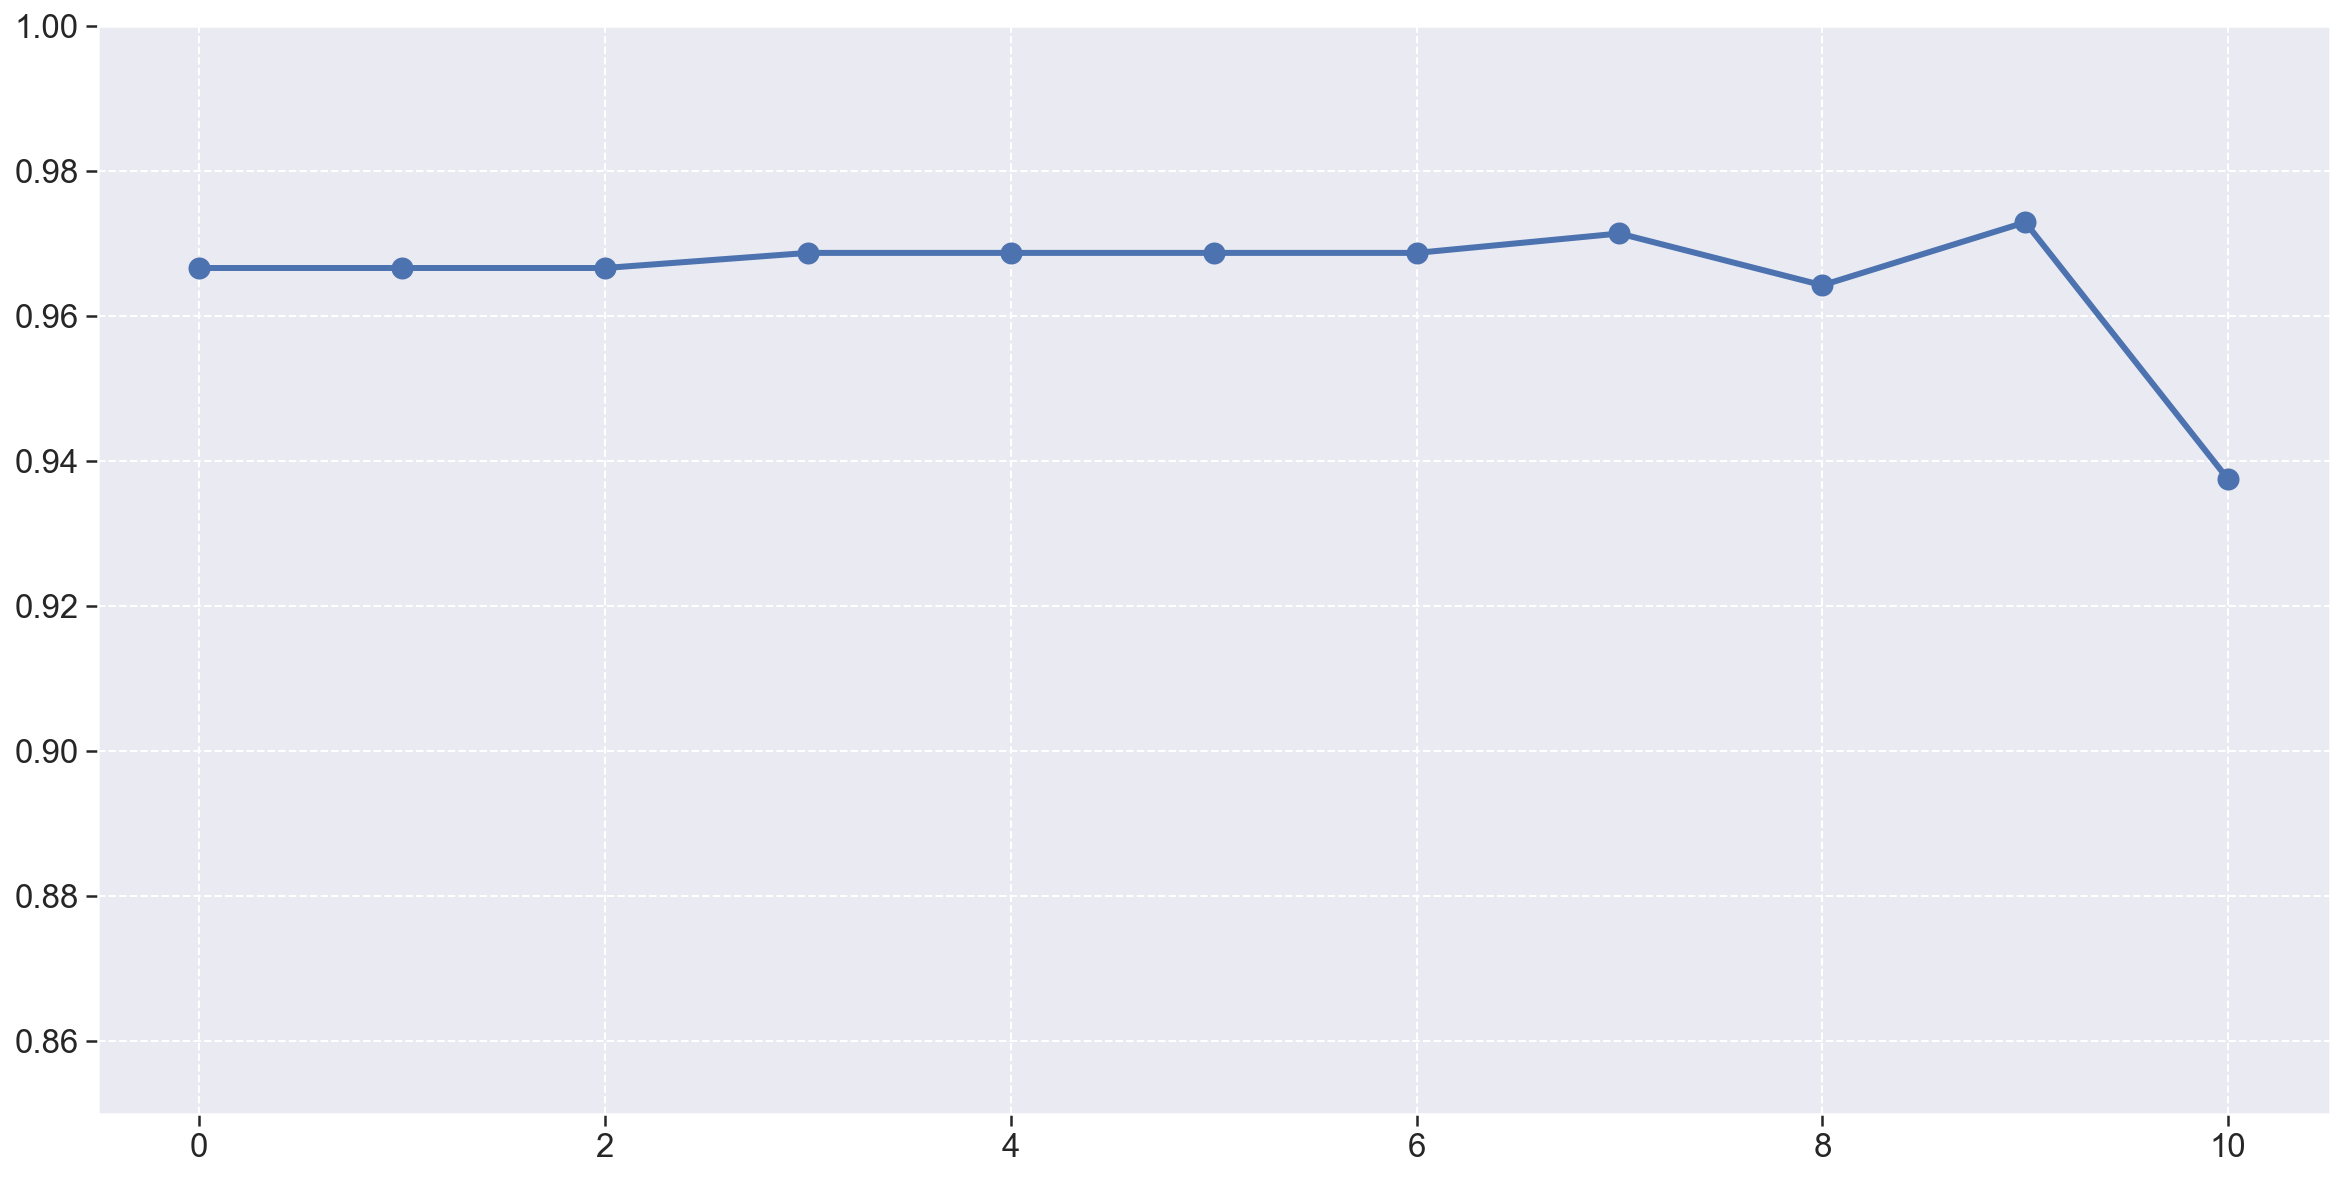

In [97]:
fig = plt.figure(figsize=(20, 10))

# Background color
plt.axhspan(-.001,.016, color="#c9f9ff", alpha=0.3)

#plt.plot(repos_metrics_list[0]['em1'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em1'], linewidth=3, marker='o', markersize=10)

plt.ylim(.85,1)

### em2

(-0.001, 0.2)

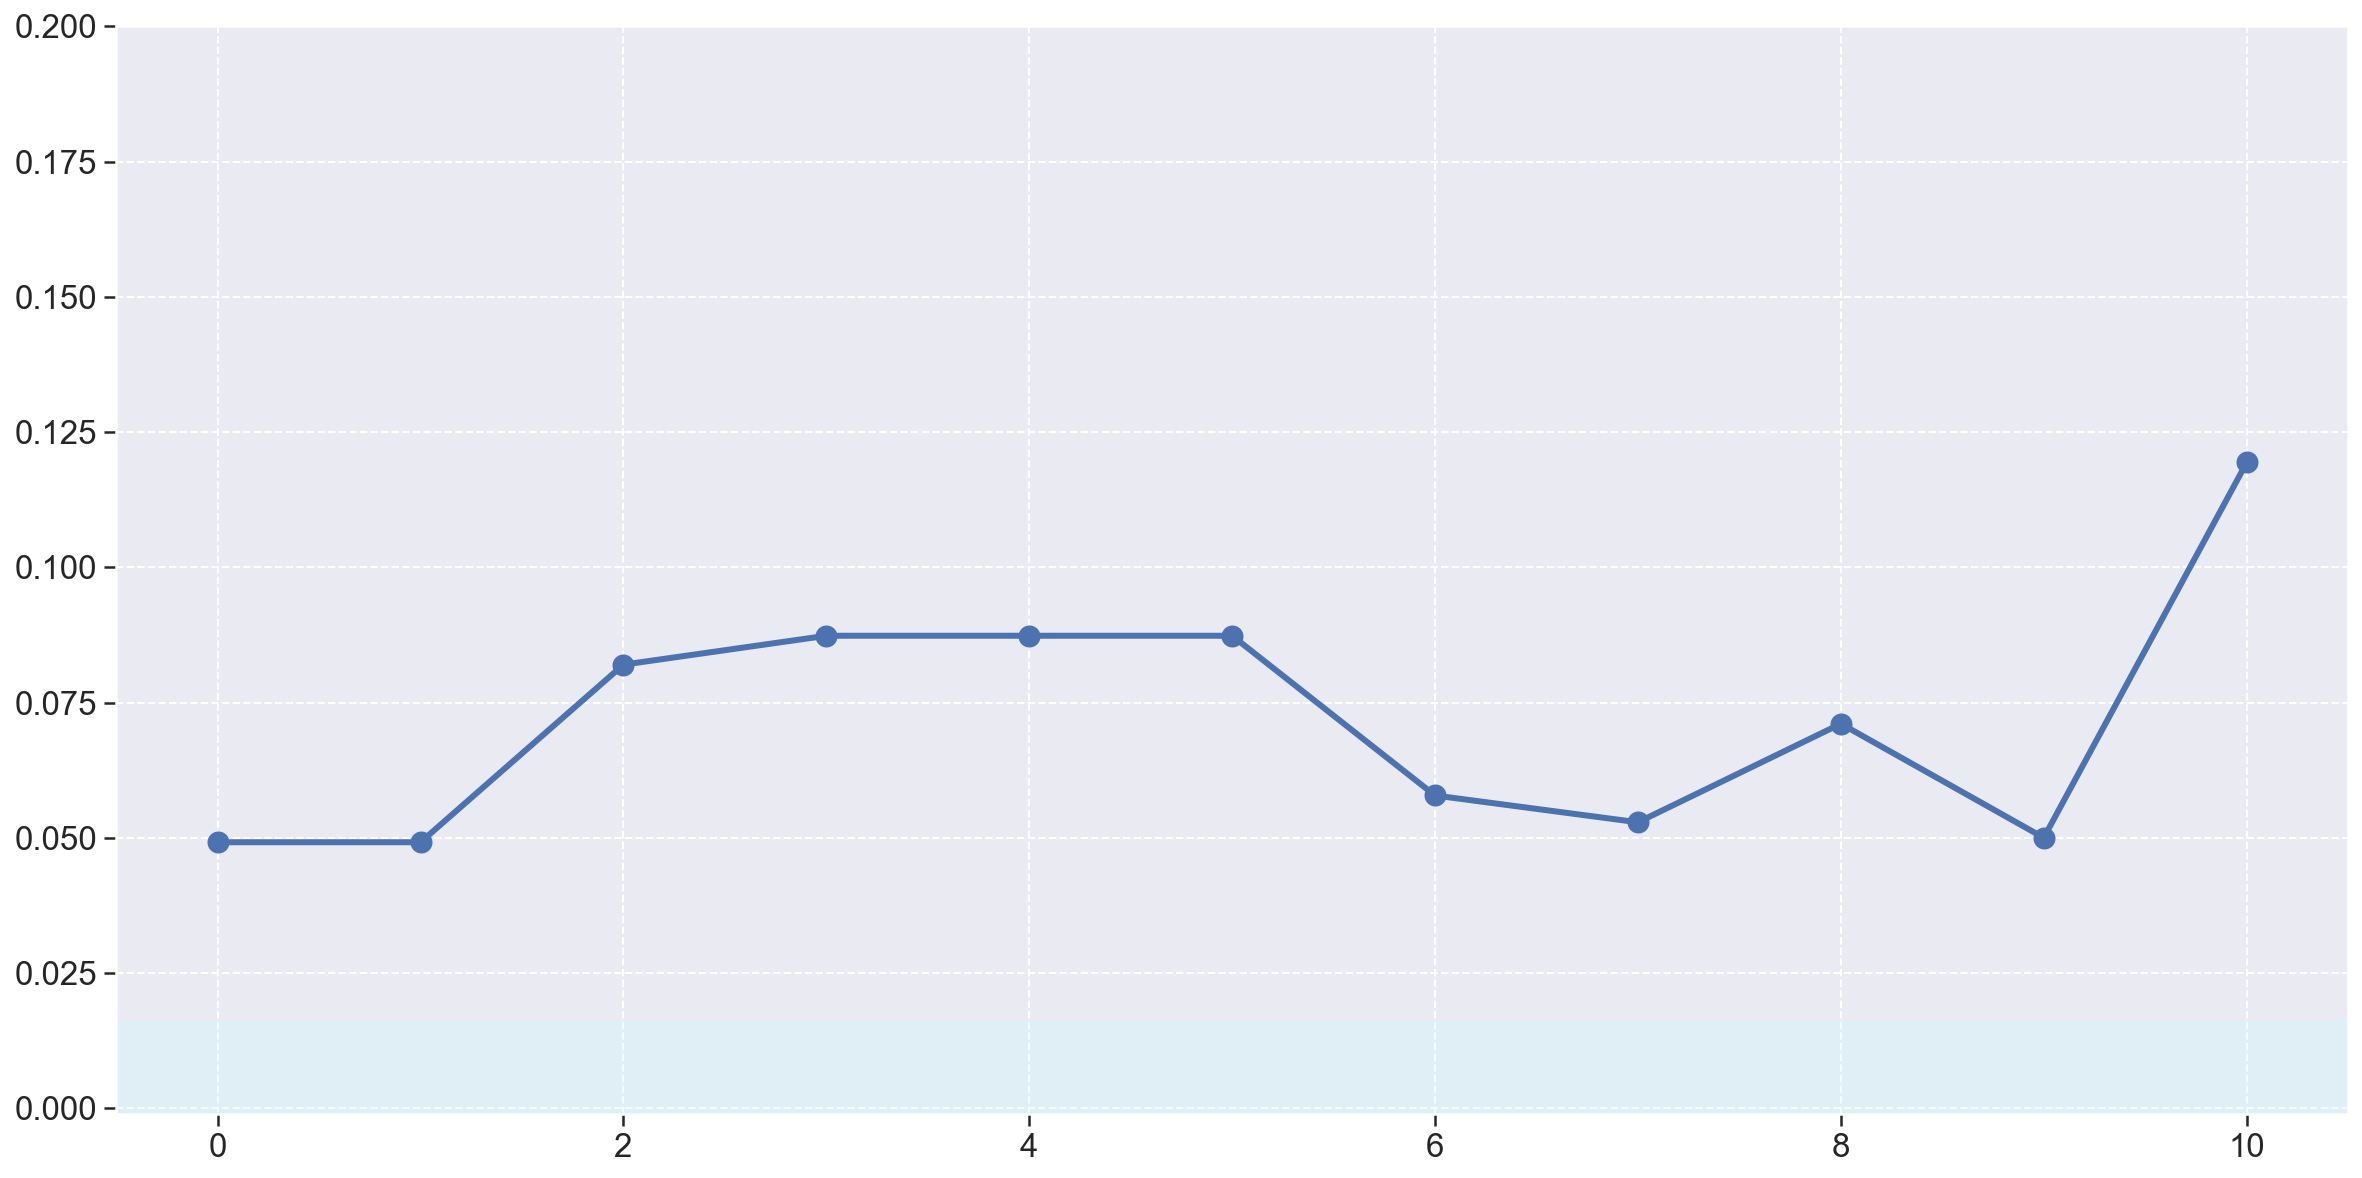

In [103]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em2'], linewidth=3, marker='o', markersize=10)


# Background color
plt.axhspan(-.001,.016, color="#c9f9ff", alpha=0.3)

plt.ylim(-.001,.2)

### em3

(0.75, 1.01)

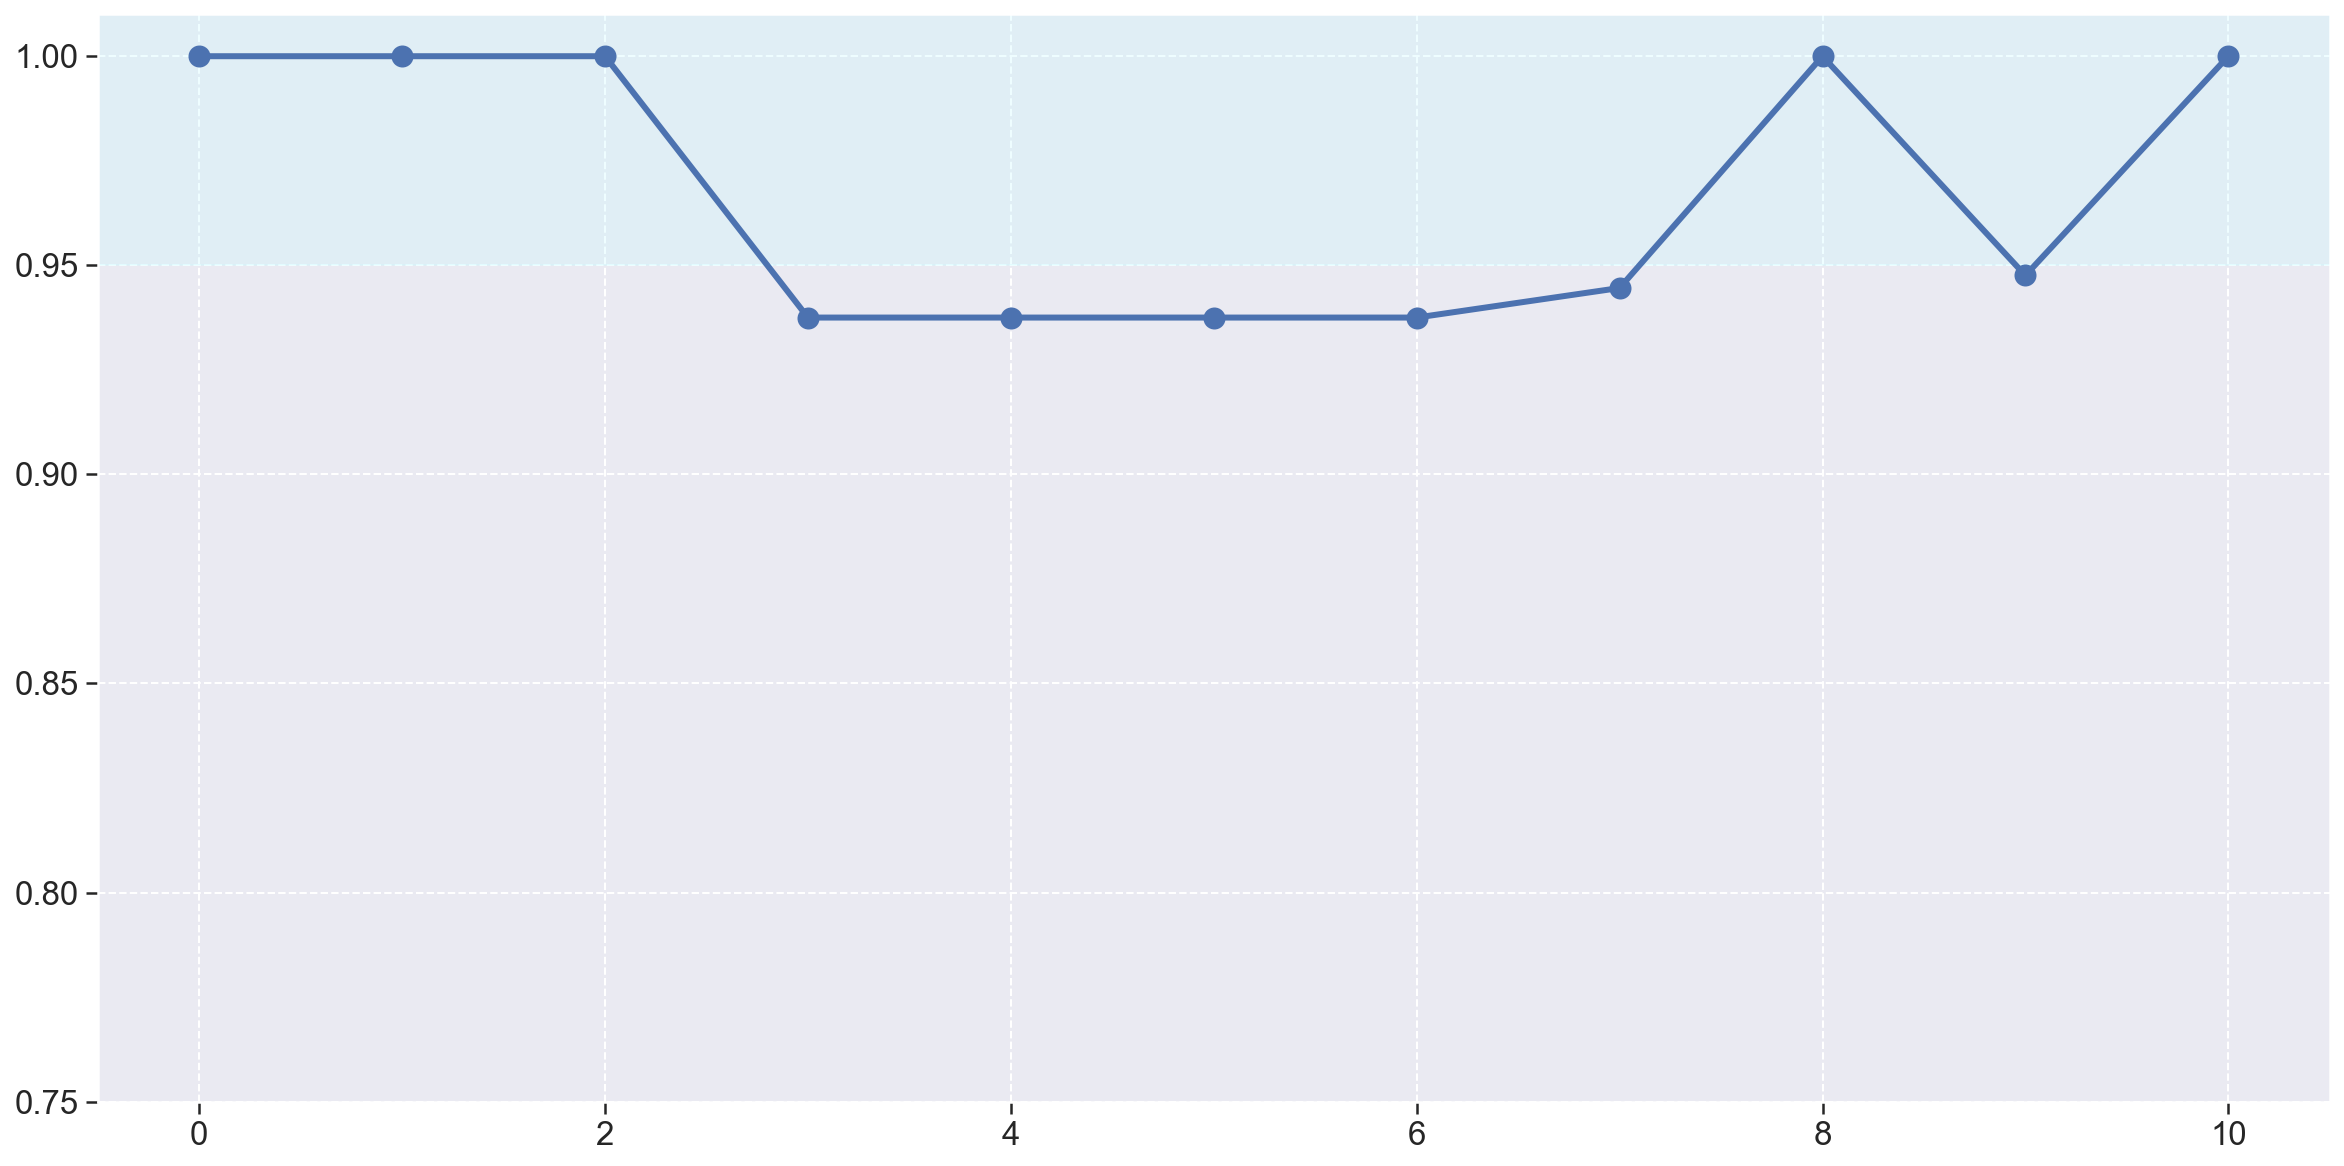

In [104]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.95,1.01, color="#c9f9ff", alpha=0.3)

plt.ylim(.75,1.01)

### All metrics

(-0.02, 1.02)

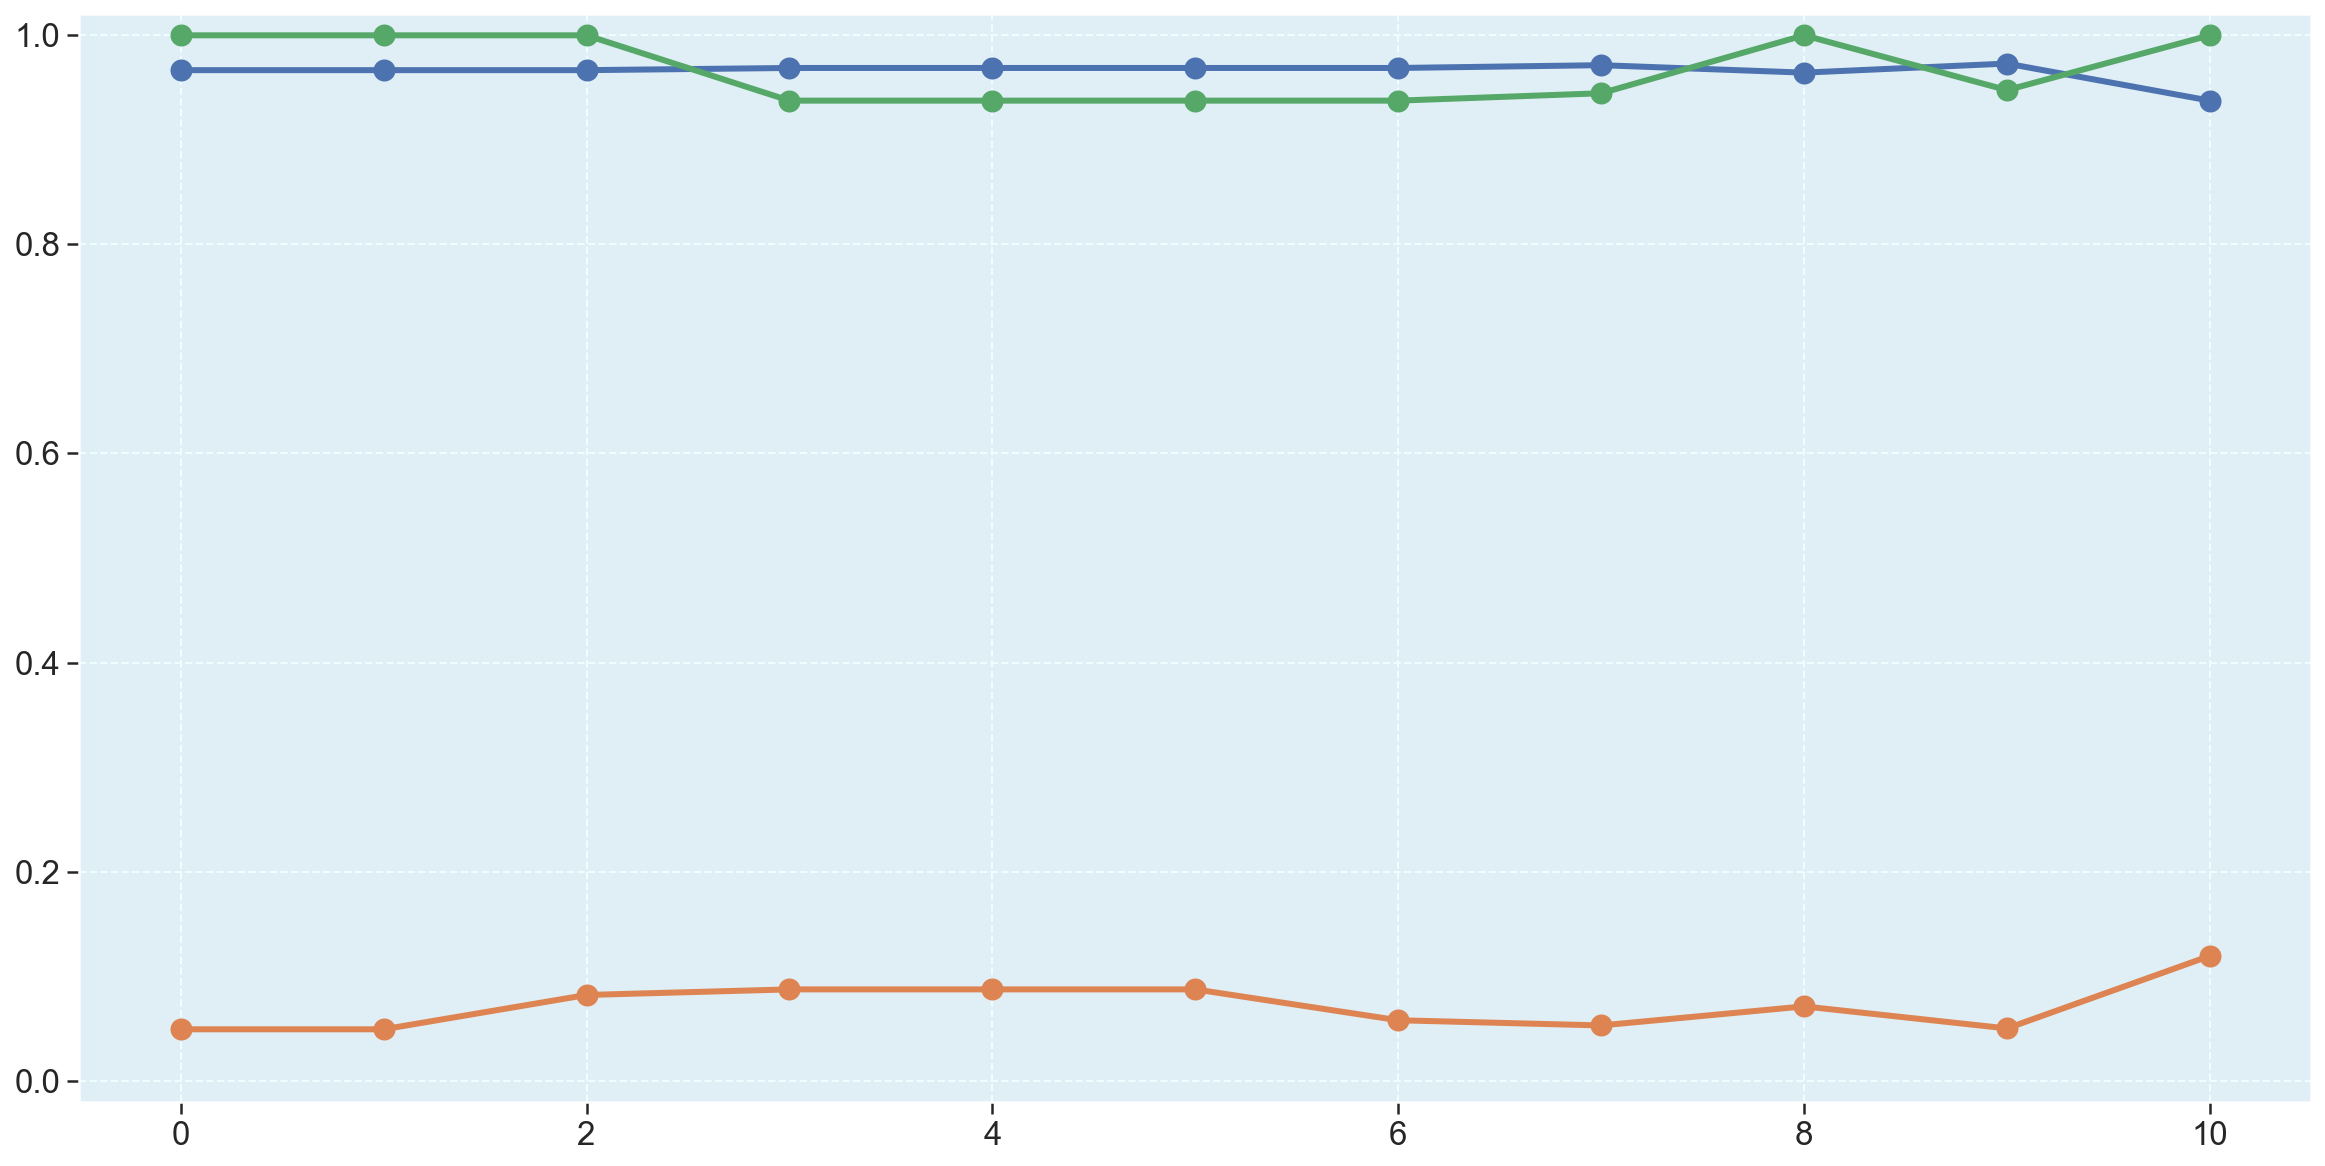

In [71]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em1'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em2'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

### Setting measures weighs

In [72]:
# wem1 = 33%
# wem2 = 33%
# wem3 = 33%

wem1=wem2=wem3 = 0.3374
SC_Modifiability_EM_Weights = np.array([wem1, wem2, wem3])

## Defining Modifiability quality sub-characteristic tensors per microservice.

In [73]:
def create_sc_tensor(measures_list, size_z):

    tensor_sc_measures = ts.tensor(measures_list).reshape((measures_list.shape[0],measures_list.shape[1],size_z))

    return tensor_sc_measures

repos_sc_measures_list = []

for repo_measures in repos_metrics_list:
    repos_sc_measures_list.append(np.array([repo_measures['em1'].astype(float),
                                            repo_measures['em2'].astype(float),
                                            repo_measures['em3'].astype(float)]))

t_sc_modifiability_tensor_list = []

t_sc_modifiability_tensor_list.append(create_sc_tensor(repos_sc_measures_list[0], 1))
t_sc_modifiability_tensor_list.append(create_sc_tensor(repos_sc_measures_list[1], 1))
t_sc_modifiability_tensor_list.append(create_sc_tensor(repos_sc_measures_list[2], 1))
t_sc_modifiability_tensor_list.append(create_sc_tensor(repos_sc_measures_list[3], 1))
t_sc_modifiability_tensor_list.append(create_sc_tensor(repos_sc_measures_list[4], 1))
t_sc_modifiability_tensor_list.append(create_sc_tensor(repos_sc_measures_list[5], 1))

print("Modifiability Tensor dimensions = " + str(t_sc_modifiability_tensor_list[0].ndim))

t_sc_modifiability_tensor_list[0]

Modifiability Tensor dimensions = 3


array([[[0.96666667],
        [0.96666667],
        [0.96666667],
        [0.96875   ],
        [0.96875   ],
        [0.96875   ],
        [0.96875   ],
        [0.97142857],
        [0.96428571],
        [0.97297297],
        [0.9375    ]],

       [[0.04916667],
        [0.04916667],
        [0.082     ],
        [0.08734375],
        [0.08734375],
        [0.08734375],
        [0.0578125 ],
        [0.05285714],
        [0.07107143],
        [0.05      ],
        [0.119375  ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        [0.9375    ],
        [0.9375    ],
        [0.9375    ],
        [0.9375    ],
        [0.94457143],
        [1.        ],
        [0.94756757],
        [1.        ]]])

# Weighting tensor of the Modifiability Sub-Characteristic at measure level.

In [74]:
t_sc_modifiability_weighted_list = []

for i in range(len(t_sc_modifiability_tensor_list)):

    t_sc_modifiability_weighted = np.empty(t_sc_modifiability_tensor_list[i].shape)

    # t_sc_modifiability_frontend[:, :, 0][j] = Slice in a specific dimension and multiply by respective weight
    for j in range(t_sc_modifiability_tensor_list[i].ndim):
        t_sc_modifiability_weighted[:, :, 0][j] = np.tensordot(t_sc_modifiability_tensor_list[i][:,:,0][j],
                                                               SC_Modifiability_EM_Weights[j], 0)
    t_sc_modifiability_weighted_list.append(t_sc_modifiability_weighted)

t_sc_modifiability_weighted_list[0]


array([[[0.32615333],
        [0.32615333],
        [0.32615333],
        [0.32685625],
        [0.32685625],
        [0.32685625],
        [0.32685625],
        [0.32776   ],
        [0.32535   ],
        [0.32828108],
        [0.3163125 ]],

       [[0.01658883],
        [0.01658883],
        [0.0276668 ],
        [0.02946978],
        [0.02946978],
        [0.02946978],
        [0.01950594],
        [0.017834  ],
        [0.0239795 ],
        [0.01687   ],
        [0.04027712]],

       [[0.3374    ],
        [0.3374    ],
        [0.3374    ],
        [0.3163125 ],
        [0.3163125 ],
        [0.3163125 ],
        [0.3163125 ],
        [0.3186984 ],
        [0.3374    ],
        [0.3197093 ],
        [0.3374    ]]])

# Aggregating and weighting SC_Modifiability quality characteristic tensor

In [75]:
wsc1 = 1

t_sc_modifiability_agregated_list = []

for i in range(len(t_sc_modifiability_weighted_list)):

    t_sc_modifiability_agregated = np.empty([t_sc_modifiability_weighted_list[i].shape[1]])

    for j in range(t_sc_modifiability_weighted_list[i].shape[1]):
        t_sc_modifiability_agregated[j] = np.linalg.norm(t_sc_modifiability_weighted_list[i][:,:,0][:,j])

    t_sc_modifiability_agregated_list.append(np.tensordot(t_sc_modifiability_agregated, wsc1, 0))

t_sc_modifiability_agregated_list[0]

array([0.46956357, 0.46956357, 0.47008532, 0.45580377, 0.45580377,
       0.45580377, 0.45526815, 0.45750775, 0.46932547, 0.45854891,
       0.46423551])

# Agregating and Weighting Maintainability quality characteristic tensor

In [76]:
wc1 = 1

t_c_maintainability_agregated_list = []

for i in range(len(t_sc_modifiability_agregated_list)):

    t_c_maintainability_agregated = np.empty([t_sc_modifiability_agregated_list[i].shape[0]])

    for j in range(t_sc_modifiability_agregated_list[i].shape[0]):
        t_c_maintainability_agregated[j] = np.linalg.norm(t_sc_modifiability_weighted_list[i][:,:,0][:,j])

    t_c_maintainability_agregated_list.append(np.tensordot(t_c_maintainability_agregated, wc1, 0))

t_c_maintainability_agregated_list[0]


array([0.46956357, 0.46956357, 0.47008532, 0.45580377, 0.45580377,
       0.45580377, 0.45526815, 0.45750775, 0.46932547, 0.45854891,
       0.46423551])

# Comparison of the product quality of two Releases. This comparison is obtained from cosine similarity between tensors.

In [105]:
SQC_1 = t_c_maintainability_agregated_list[0][0] # first_release from frontend repository
SQC_2 = t_c_maintainability_agregated_list[0][10] # last_release from frontend repository

distance.cosine(SQC_1, SQC_2)

1.1102230246251565e-16

# Intensity of difference between releases comparison

In [106]:
intensity_difference = SQC_2 - SQC_1

intensity_difference

-0.005328064583348391

In [79]:
for i in range(len(repos_metrics_list)):
    repos_metrics_list[i]['Modifiability'] = t_c_maintainability_agregated_list[i].tolist()
    repos_metrics_list[i]['Maintainability'] = t_c_maintainability_agregated_list[i].tolist()
    repos_metrics_list[i]['SQC'] = t_c_maintainability_agregated_list[i].tolist()


column_names = ["em1", "em2", "em3", "repository", "version", "Modifiability", "Maintainability", "SQC" ]

repos_metrics_list[0]

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.966667,0.049167,1.000000,frontend,01-05-2021,0.469564,0.469564,0.469564
1,0.966667,0.049167,1.000000,frontend,02-05-2021,0.469564,0.469564,0.469564
2,0.966667,0.082000,1.000000,frontend,04-05-2021,0.470085,0.470085,0.470085
3,0.968750,0.087344,0.937500,frontend,09-05-2021,0.455804,0.455804,0.455804
4,0.968750,0.087344,0.937500,frontend,09-05-2021(1),0.455804,0.455804,0.455804
5,0.968750,0.087344,0.937500,frontend,09-05-2021(2),0.455804,0.455804,0.455804
6,0.968750,0.057813,0.937500,frontend,10-05-2021,0.455268,0.455268,0.455268
7,0.971429,0.052857,0.944571,frontend,10-05-2021(1),0.457508,0.457508,0.457508
8,0.964286,0.071071,1.000000,frontend,18-04-2021,0.469325,0.469325,0.469325
9,0.972973,0.050000,0.947568,frontend,19-05-2021,0.458549,0.458549,0.458549


# Plotting the total quality(SQC) from PARLAMENTAQUI frontend microservice

(0.4, 0.5)

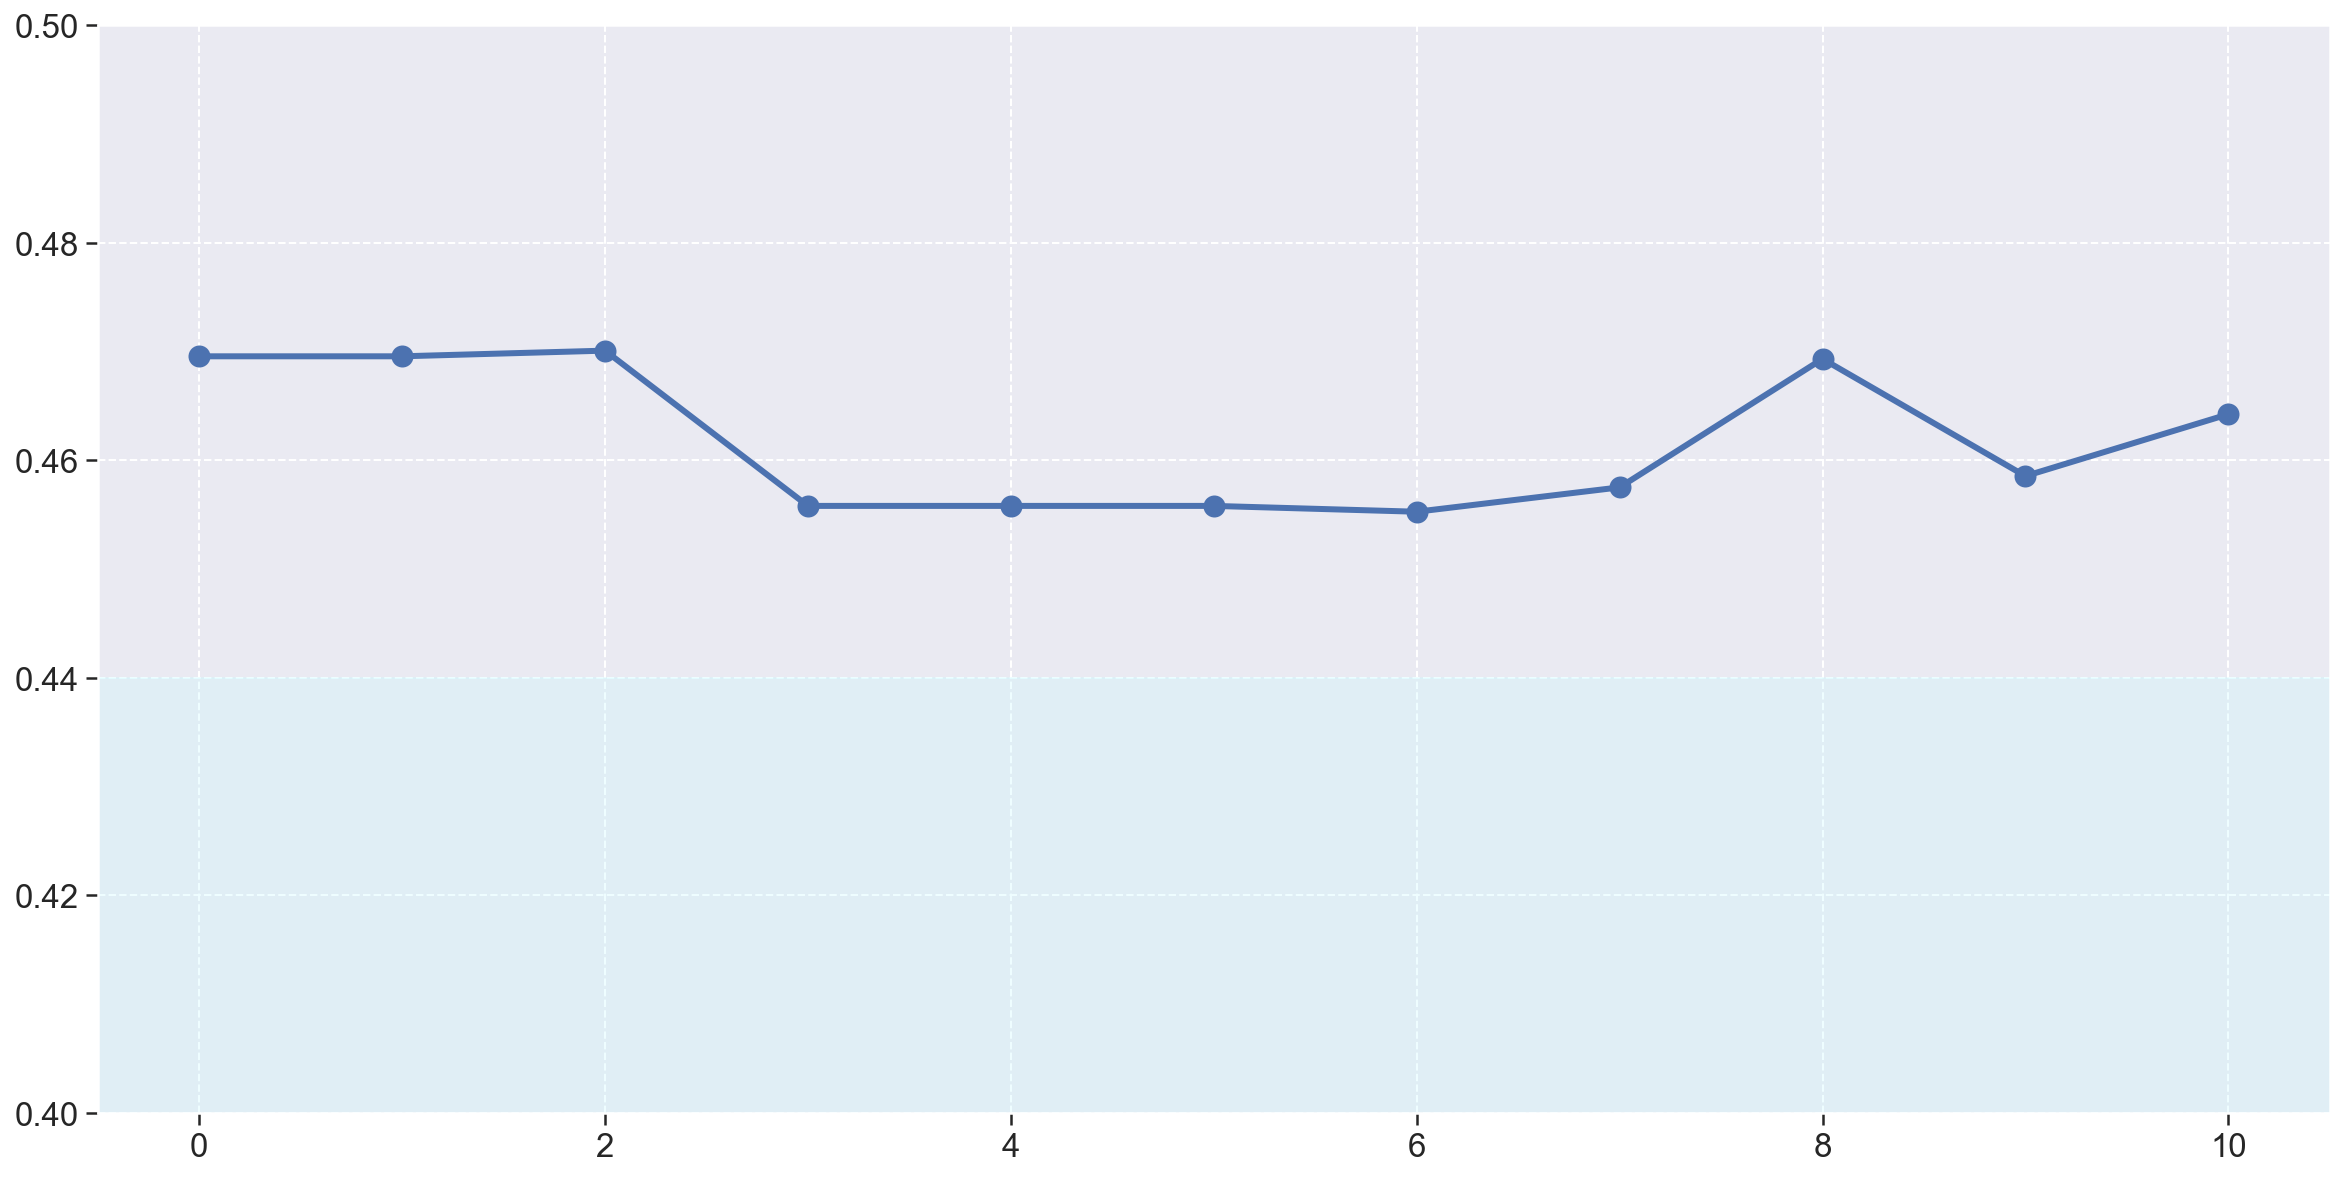

In [80]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repository_metrics["frontend"]['SQC'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.32,.44, color="#c9f9ff", alpha=0.3)

plt.ylim(.4,.5)

# Plotting the total quality(SQC) from all PARLAMENTAQUI microservices

(0.3, 0.5)

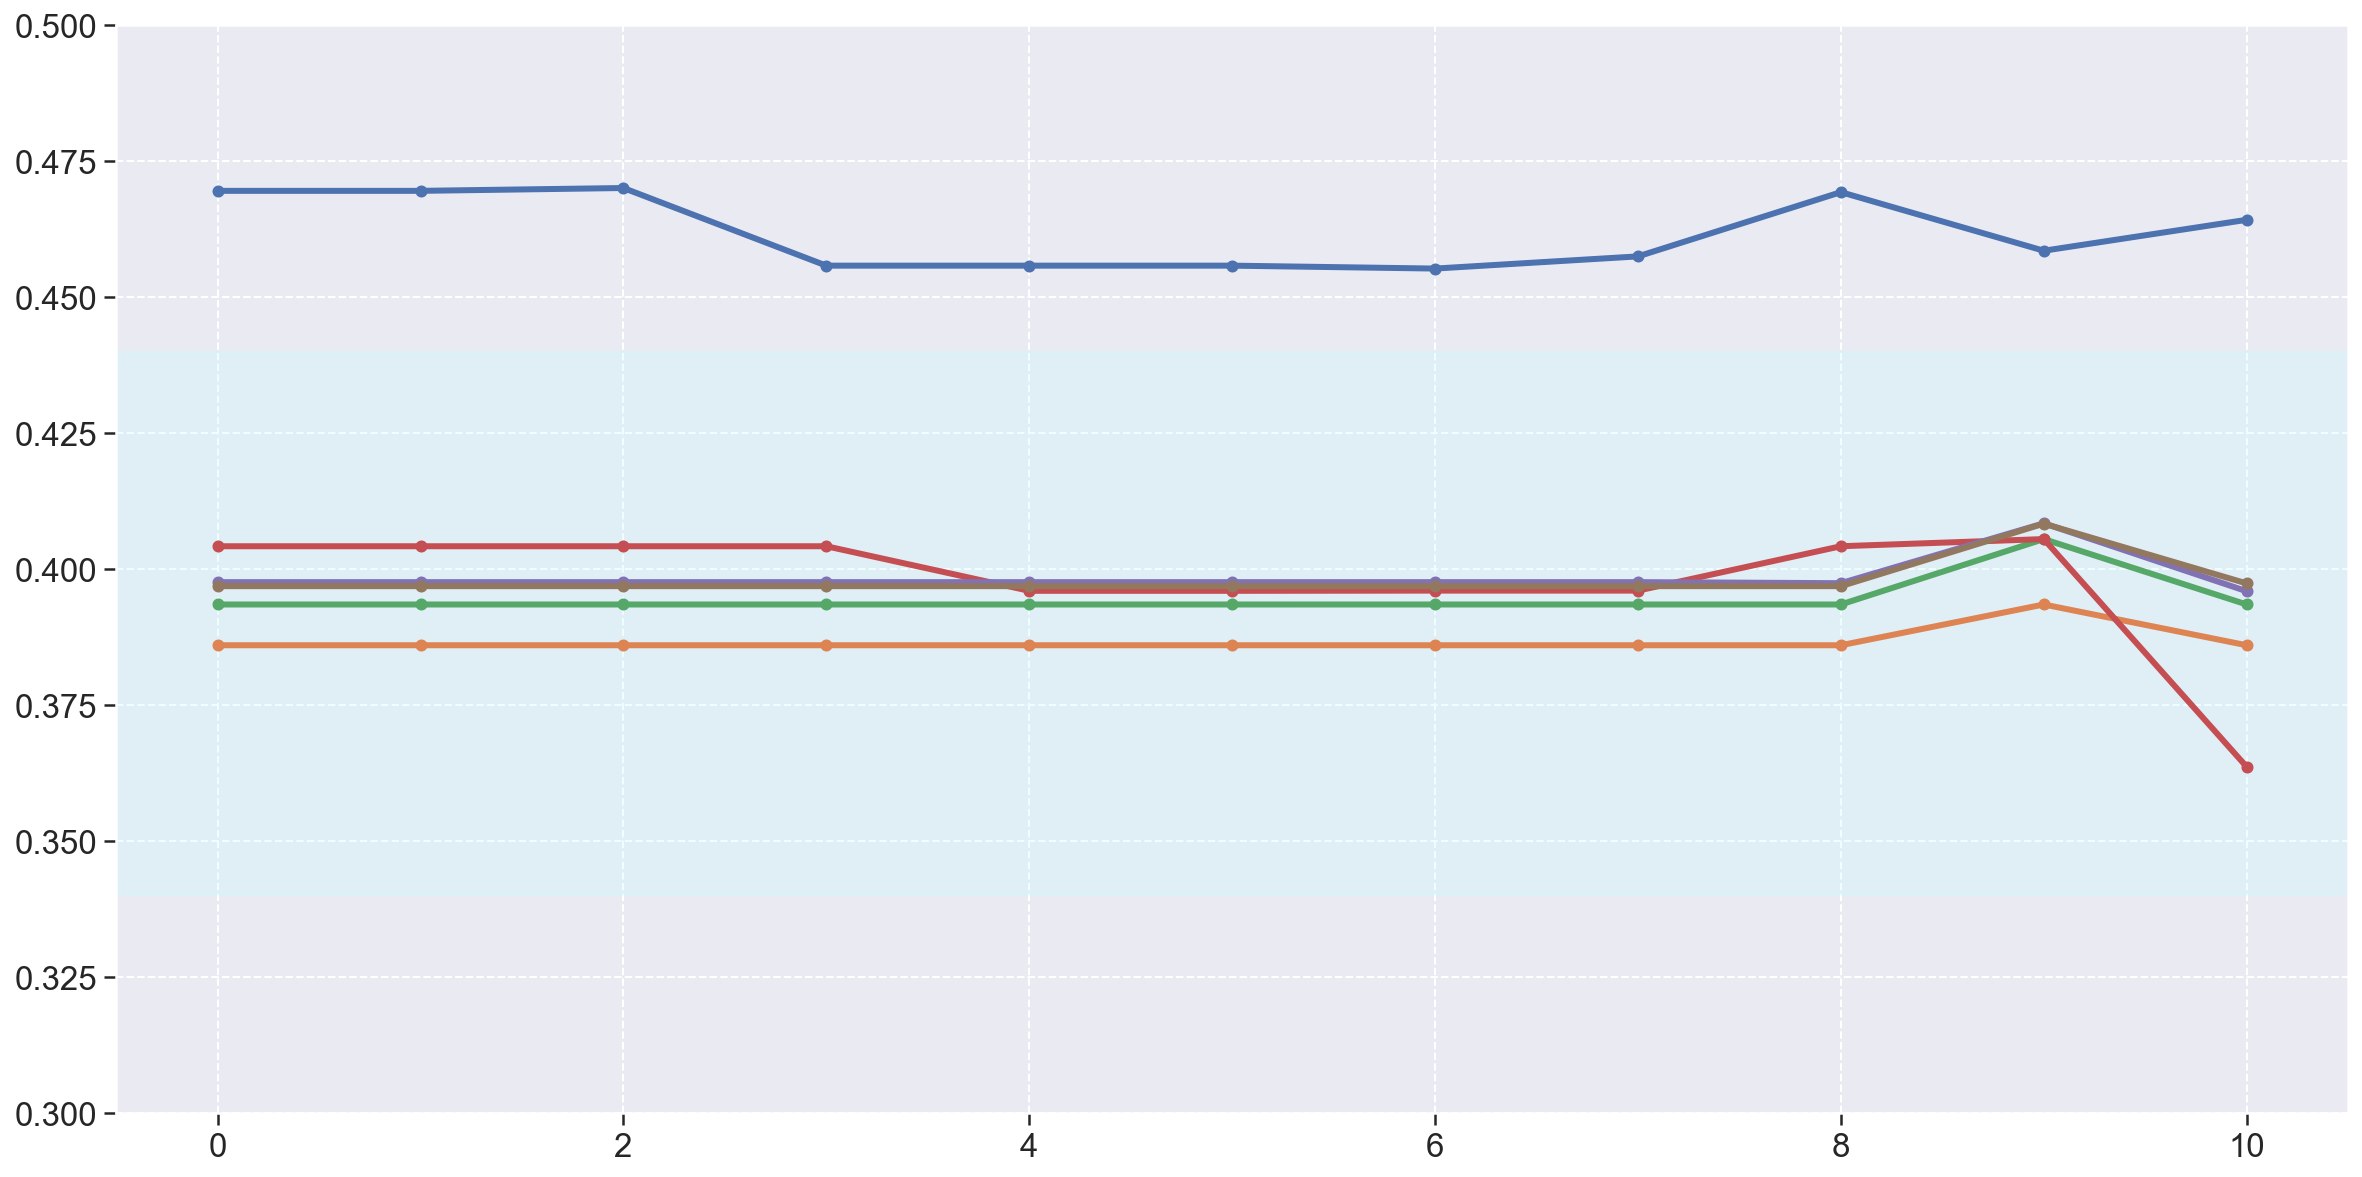

In [81]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(repos_metrics_list[1]['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(repos_metrics_list[2]['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(repos_metrics_list[3]['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(repos_metrics_list[4]['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(repos_metrics_list[5]['SQC'], linewidth=3, marker='o', markersize=5)

# Background color
plt.axhspan(.34,.44, color="#c9f9ff", alpha=0.3)

plt.ylim(.3,.5)

# Plotting the dataset with MeasureSoftGram's calculations

In [82]:
metrics_df = pd.concat([repository_metrics["frontend"],
                        repository_metrics["gateway"],
                        repository_metrics["etl_tse"],
                        repository_metrics["etl_twitter"],
                        repository_metrics["etl_camara"],
                        repository_metrics["etl_news"]],ignore_index=True)

metrics_df

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.966667,0.049167,1.000000,frontend,01-05-2021,0.469564,0.469564,0.469564
1,0.966667,0.049167,1.000000,frontend,02-05-2021,0.469564,0.469564,0.469564
2,0.966667,0.082000,1.000000,frontend,04-05-2021,0.470085,0.470085,0.470085
3,0.968750,0.087344,0.937500,frontend,09-05-2021,0.455804,0.455804,0.455804
4,0.968750,0.087344,0.937500,frontend,09-05-2021(1),0.455804,0.455804,0.455804
5,0.968750,0.087344,0.937500,frontend,09-05-2021(2),0.455804,0.455804,0.455804
6,0.968750,0.057813,0.937500,frontend,10-05-2021,0.455268,0.455268,0.455268
7,0.971429,0.052857,0.944571,frontend,10-05-2021(1),0.457508,0.457508,0.457508
8,0.964286,0.071071,1.000000,frontend,18-04-2021,0.469325,0.469325,0.469325
9,0.972973,0.050000,0.947568,frontend,19-05-2021,0.458549,0.458549,0.458549


# Generating dataset in .CSV format

In [83]:
metrics_df.to_excel('data/fga-eps-mds-2020-2-data/parlamentaqui/measuresoftgram-parlamentaqui-dataset-23-03-2021-24-05-2021-excel.xlsx', header=False, index = False)
metrics_df.to_csv('data/fga-eps-mds-2020-2-data/parlamentaqui/measuresoftgram-parlamentaqui-dataset-23-03-2021-24-05-2021-csv.csv', header=False, index = False)
#metrics_df.to_json('data/metrics_df_json.json', index = False)


# Reading MeasureSoftGram and Q-Rapids dataset .CSV

In [84]:
qrapids_df = pd.read_csv('data/fga-eps-mds-2020-2-data/parlamentaqui/qrapids-parlamentaqui-dataset-23-03-2021-24-05-2021-csv.csv', sep=',', header=None,
                              names=['m1', 'm2', 'm3', 'repository', 'version', 'asc1', 'ac1','total'], dtype='a')

qrapids_df

,m1,m2,m3,repository,version,asc1,ac1,total
0,0.9666666666666667,0.06666666666666667,1.0,frontend,01-05-2021,0.671,0.671,0.671
1,0.9666666666666667,0.06666666666666667,1.0,frontend,02-05-2021,0.671,0.671,0.671
2,0.9666666666666667,0.1,1.0,frontend,04-05-2021,0.6819999999999999,0.6819999999999999,0.6819999999999999
3,0.96875,0.09375,0.9375,frontend,09-05-2021,0.66,0.66,0.66
4,0.96875,0.09375,0.9375,frontend,09-05-2021(1),0.66,0.66,0.66
5,0.96875,0.09375,0.9375,frontend,09-05-2021(2),0.66,0.66,0.66
6,0.96875,0.0625,0.9375,frontend,10-05-2021,0.6496875,0.6496875,0.6496875
7,0.9714285714285714,0.05714285714285714,0.9714285714285714,frontend,10-05-2021(1),0.6599999999999999,0.6599999999999999,0.6599999999999999
8,0.9642857142857143,0.10714285714285714,1.0,frontend,18-04-2021,0.6835714285714286,0.6835714285714286,0.6835714285714286
9,0.972972972972973,0.05405405405405406,0.972972972972973,frontend,19-05-2021,0.6600000000000001,0.6600000000000001,0.6600000000000001


In [85]:
measuresoftgram_df = pd.read_csv('data/fga-eps-mds-2020-2-data/parlamentaqui/measuresoftgram-parlamentaqui-dataset-23-03-2021-24-05-2021-csv.csv', sep=',',
                                 header=None, names=column_names, dtype='a')

measuresoftgram_df

,em1,em2,em3,repository,version,Modifiability,Maintainability,SQC
0,0.9666666666666667,0.049166666666666664,1.0,frontend,01-05-2021,0.46956356996237,0.46956356996237,0.46956356996237
1,0.9666666666666667,0.049166666666666664,1.0,frontend,02-05-2021,0.46956356996237,0.46956356996237,0.46956356996237
2,0.9666666666666667,0.082,1.0,frontend,04-05-2021,0.47008532062454833,0.47008532062454833,0.47008532062454833
3,0.96875,0.08734375,0.9375,frontend,09-05-2021,0.45580376679798873,0.45580376679798873,0.45580376679798873
4,0.96875,0.08734375,0.9375,frontend,09-05-2021(1),0.45580376679798873,0.45580376679798873,0.45580376679798873
5,0.96875,0.08734375,0.9375,frontend,09-05-2021(2),0.45580376679798873,0.45580376679798873,0.45580376679798873
6,0.96875,0.0578125,0.9375,frontend,10-05-2021,0.45526814891673056,0.45526814891673056,0.45526814891673056
7,0.9714285714285714,0.05285714285714286,0.9445714285714286,frontend,10-05-2021(1),0.4575077478235314,0.4575077478235314,0.4575077478235314
8,0.9642857142857143,0.07107142857142858,1.0,frontend,18-04-2021,0.4693254722687124,0.4693254722687124,0.4693254722687124
9,0.972972972972973,0.05,0.9475675675675677,frontend,19-05-2021,0.4585489067417945,0.4585489067417945,0.4585489067417945


# Statics Treatments

In [86]:
def is_normal(dist, alpha):

    k2, normal_Test_Pval = stats.normaltest(dist, axis=None)

    if (normal_Test_Pval > alpha): # alpha value is 0.05 or 5%
        return False

    return True

In [87]:
# alpha value is 0.05 or 5%
alpha = np.float64(0.05)

dist_control = qrapids_df["total"].to_numpy('float')
dist_predict = measuresoftgram_df["SQC"].to_numpy('float')


# Descriptive Statistics

In [88]:
print('Descriptive Statitics from Q-Rapids: '+ str(stats.describe(dist_control)))
print('Min: ' + str(dist_control.min(axis=0)))
print('Max: ' + str(dist_control.max(axis=0)))
print('Mean: '+ str(dist_control.mean(axis=0)))
print('Median: '+ str(np.median(dist_control, axis=0)))
print('Std: ' + str(dist_control.std(axis=0)))
print('Variance: ' + str(dist_control.var(axis=0)) + '\n')

print('Descriptive Statitics from MeasuresotGram: '+ str(stats.describe(dist_predict)))
print('Min: ' + str(dist_predict.min(axis=0)))
print('Max: ' + str(dist_predict.max(axis=0)))
print('Mean: '+ str(dist_predict.mean(axis=0)))
print('Median: '+ str(np.median(dist_predict, axis=0)))
print('Std: ' + str(dist_predict.std(axis=0)))
print('Variance: ' + str(dist_predict.var(axis=0)))

Descriptive Statitics from Q-Rapids: DescribeResult(nobs=66, minmax=(0.5133333333333334, 0.6835714285714286), mean=0.5859578373015873, variance=0.003061207678021795, skewness=0.18114708810236949, kurtosis=-1.1744210077337287)
Min: 0.5133333333333334
Max: 0.6835714285714286
Mean: 0.5859578373015873
Median: 0.5940000000000001
Std: 0.05490742885535903
Variance: 0.0030148257435063134

Descriptive Statitics from MeasuresotGram: DescribeResult(nobs=66, minmax=(0.36360528992637053, 0.47008532062454833), mean=0.406191771121575, variance=0.0006831466357784007, skewness=1.5441552713154285, kurtosis=1.0171220630677702)
Min: 0.36360528992637053
Max: 0.47008532062454833
Mean: 0.406191771121575
Median: 0.3968445100197809
Std: 0.025938310067845544
Variance: 0.0006727959291756976


#  Normality Test

In [89]:
print('*** Testing Normality - D’Agostino ****')
if is_normal(dist_predict, alpha):
    print("MeasuresftGram has  a normal distribution")
else:
    print("MeasuresftGram has not a normal distribution")

if is_normal(dist_control, alpha):
    print("Q-Rapids has a normal distribution")
else:
    print("Q-Rapids has not a normal distribution")

*** Testing Normality - D’Agostino ****
MeasuresftGram has  a normal distribution
Q-Rapids has a normal distribution


# Histogram

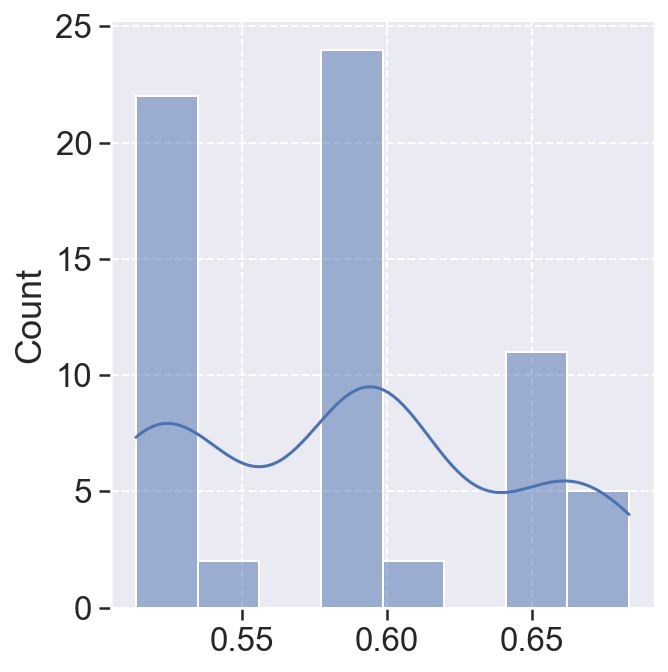

In [90]:
sns.displot(data=dist_control, kde=True)

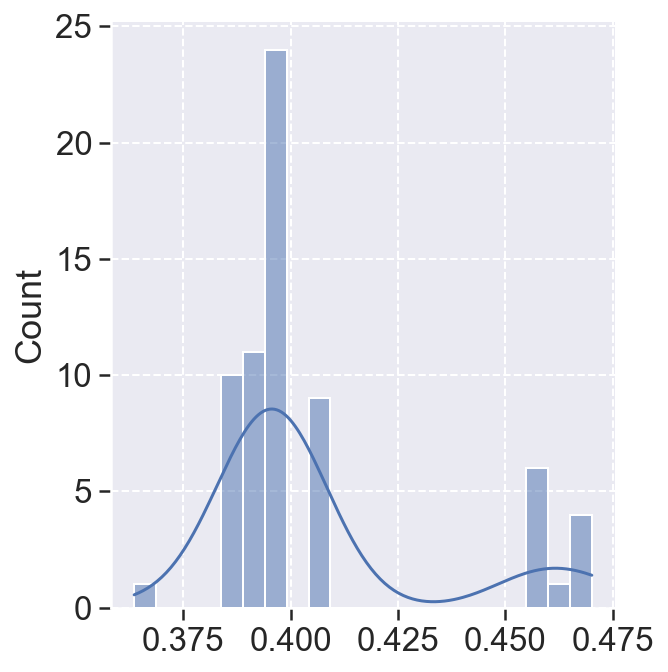

In [91]:
sns.displot(data=dist_predict, kde=True)

<Figure size 2160x1440 with 0 Axes>

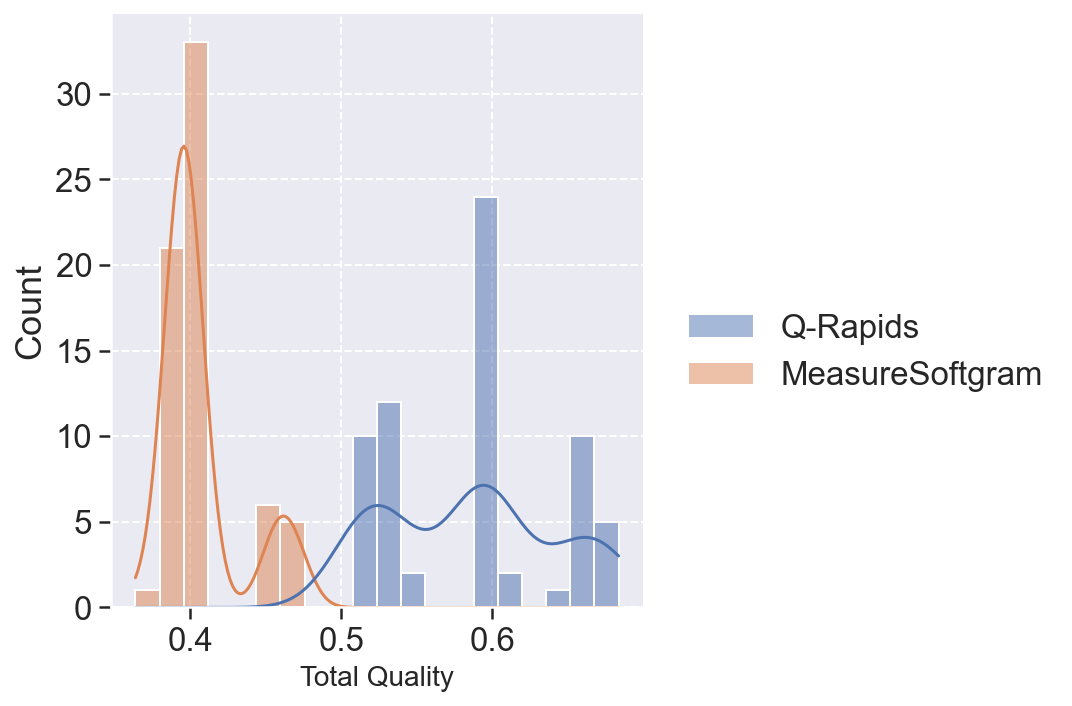

In [92]:
a = pd.DataFrame({'Q-Rapids' : qrapids_df.iloc[:,7].astype(float)})
b = pd.DataFrame({ 'MeasureSoftgram' : measuresoftgram_df.iloc[:,7].astype(float)})


df = a.append(b)

fig = plt.figure(figsize=(30, 20))

sns.displot(df, bins=20, kde=True)

plt.xlabel('Total Quality', fontsize=14)

plt.show()

# Boxplot

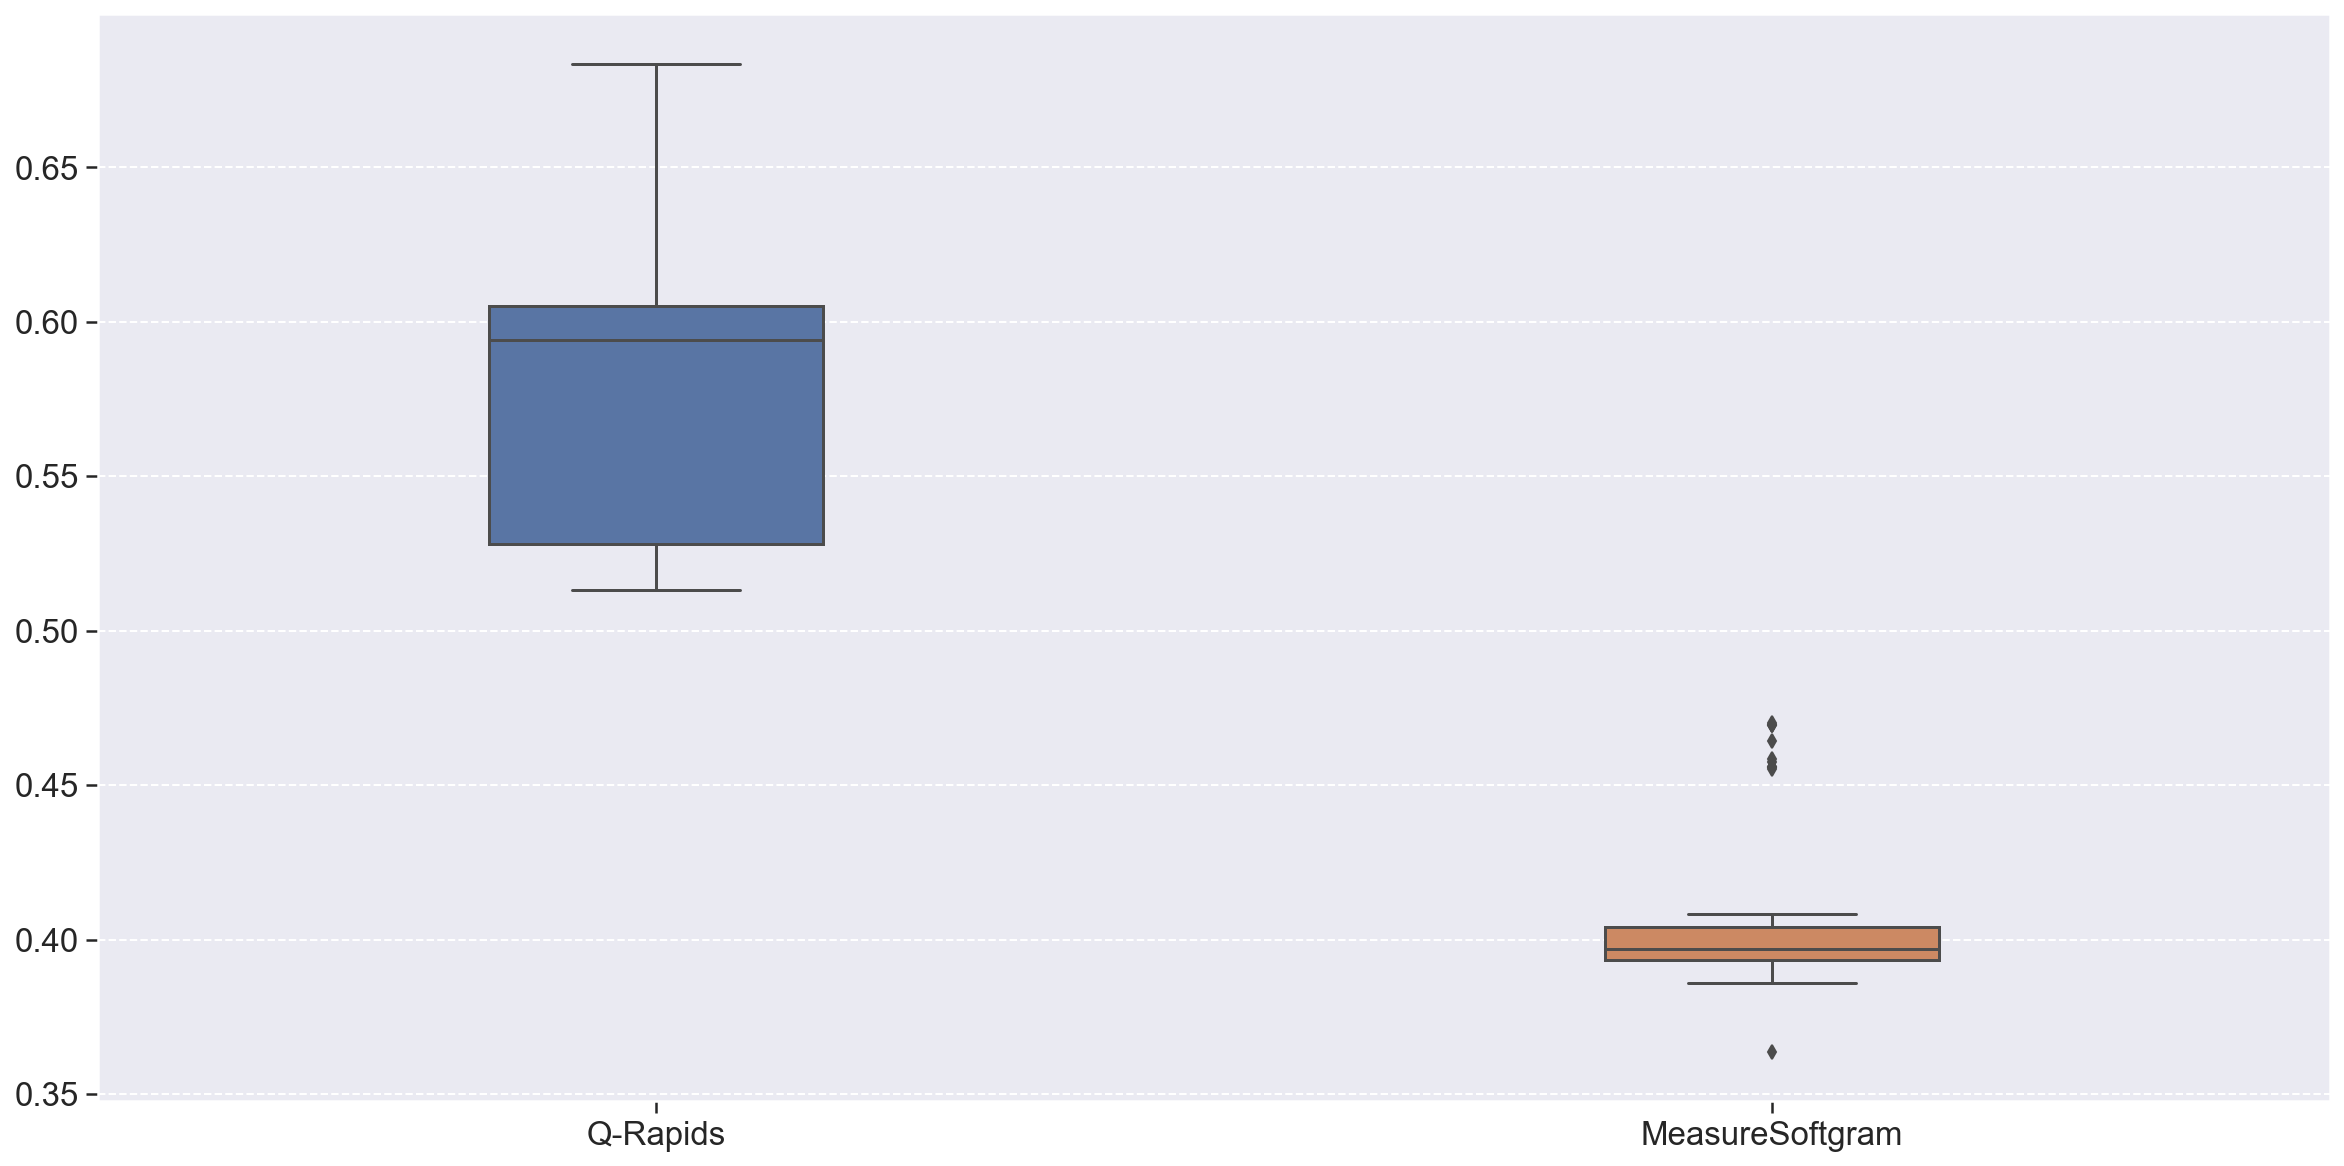

In [93]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(data=df, width=0.3)

plt.show()

# Scatter

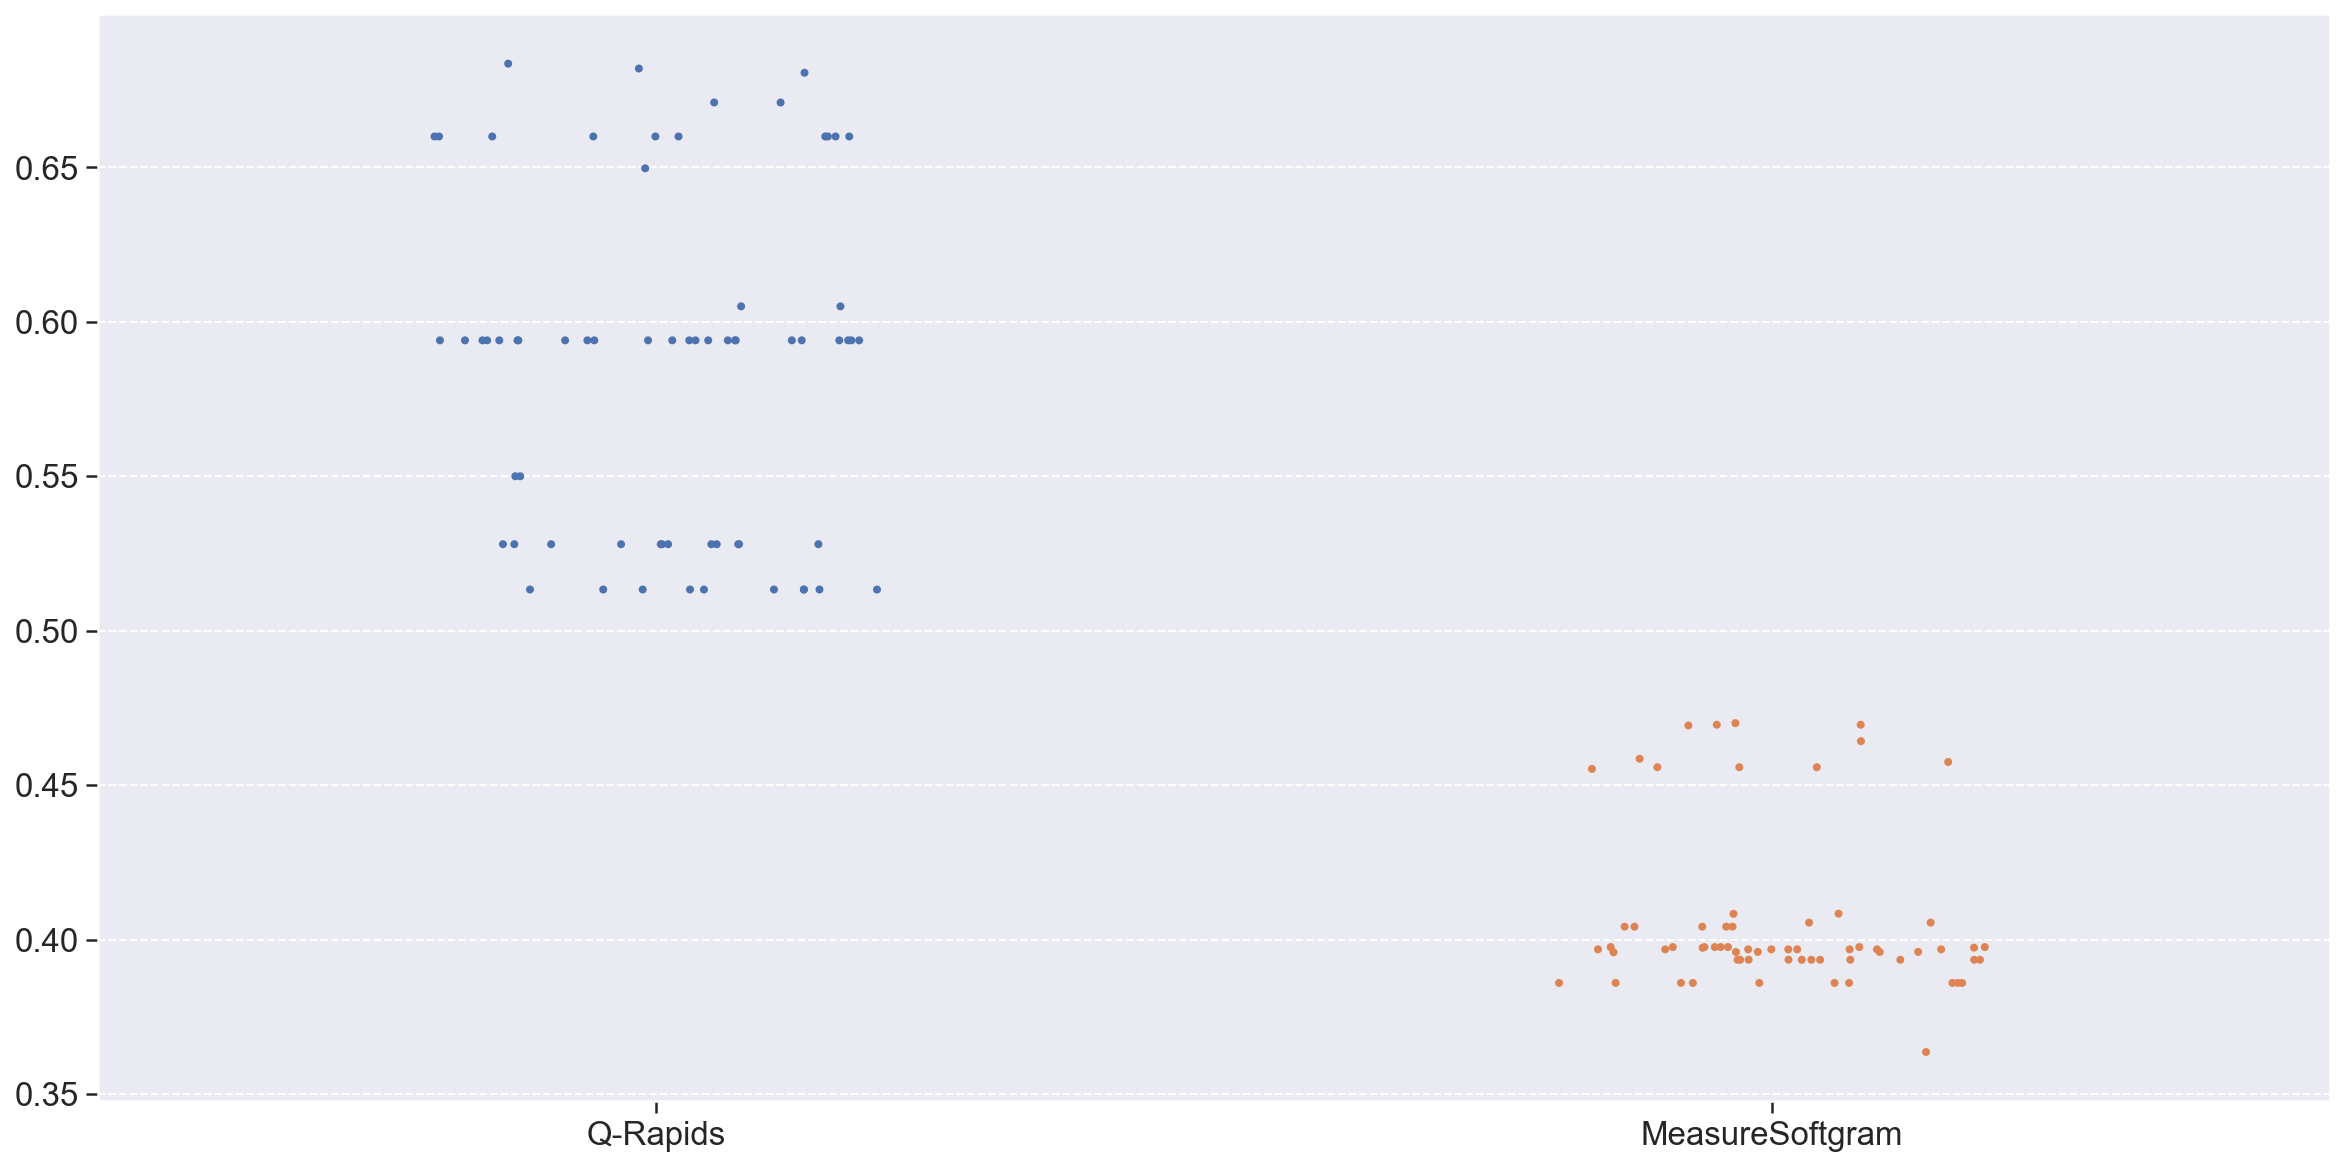

In [94]:
fig = plt.figure(figsize=(20, 10))
sns.stripplot(data=df, jitter=0.2, size=4)

plt.show()

# Hypothesis Test - **Effectiveness** - IEEE-Std-1061 Correlation Criteria - Square of the linear correlation coefficient (<em>R</em>).

#### <em>H</em><sub>1<sub>0</sub></sub>: if <em>R</em><sup>2</sup> is smaller than 0.8, it means that the variation observed in MeasureSoftGram is casual when compared with Q-Rapids.

#### <em>H</em><sub>1<sub>A</sub></sub>: if <em>R</em><sup>2</sup> is greater than 0.8, it means that at least 80% of the variation observed in MeasureSoftGram can be explained by the variation observed in Q-Rapids.

## <center> <em>H</em><sub>1<sub>0</sub></sub> : <em>R</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> < 0.8 </center>
## <center> <em>H</em><sub>1<sub>A</sub></sub> : <em>R</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> $\geq$ 0.8 </center>

In [95]:
print('**************** R-Squared *****************')

res = stats.linregress(np.ravel(dist_control), np.ravel(dist_predict))
print(f"R-squared: {res.rvalue**2:.6f}   p-value: {res.pvalue}")
print('********************************************' + '\n')

**************** R-Squared *****************
R-squared: 0.607538   p-value: 1.2669009230332568e-14
********************************************



# Hypothesis Test - **Efficiency** - IEEE-Std-1061 Tracking Criteria - Pearson correlation coefficient (<em>r</em>)

#### <em>H</em><sub>1<sub>0</sub></sub>: if <em>r</em><sup>2</sup> is smaller than 0 and close to -1, it means that the there is a high negative correlation between the two models.

#### <em>H</em><sub>1<sub>A</sub></sub>: if <em>r</em><sup>2</sup> is greater and equal than 0 and close to 1, it means that there is a high positive correlation between the two models.

## <center> <em>H</em><sub>1<sub>0</sub></sub> : <em>r</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> $\leq$ 0 </center>
## <center> <em>H</em><sub>1<sub>A</sub></sub> : <em>r</em><sup>2</sup> <sub>(measuresoftgram_SQC, qrapids_TQ)</sub> > 0 </center>

In [96]:
print('************ Person(r) test statistics *************')
r_stats, r_p_val = stats.pearsonr(np.ravel(dist_control), np.ravel(dist_predict))

print('Person(r) test statistics: '  + str(r_stats) + ' Person(r) test p-value: '  + str(r_p_val))
print('****************************************************' + '\n')


************ Person(r) test statistics *************
Person(r) test statistics: 0.7794471187633698 Person(r) test p-value: 1.2669009230332951e-14
****************************************************

